# **IMPORT MODULES**

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# **LOAD DATA**

In [3]:
point_in_time_universe = pd.read_csv("point_in_time_universe.csv")
point_in_time_universe

,2015,2016,2017,2018,2019,2020,2021
0,OXY,OXY,OXY,VZ,OXY,AXP,AXP
1,AXP,AXP,AXP,HD,AXP,MDLZ,MDLZ
2,MDLZ,MDLZ,MDLZ,ACN,MDLZ,VZ,VZ
3,VZ,VZ,VZ,WMT,VZ,BA,BA
4,BA,BA,BA,ABT,BA,CAT,CAT
...,...,...,...,...,...,...,...
97,COF,LMT,COF,COF,ABBV,COF,COF
98,TFCFA,COF,TFCFA,TFCFA,DHR,NKE,NKE
99,NKE,TFCFA,NKE,NKE,AGN,DD,DD
100,NSC,NKE,DD,DD,MS,WFC,WFC


In [4]:
point_in_time_monthly = point_in_time_universe[point_in_time_universe.columns.repeat(12)]
point_in_time_monthly.columns = [f'{a}-{b}' for a in point_in_time_universe for b in np.arange(1,13)]
point_in_time_monthly

,2015-1,2015-2,2015-3,2015-4,2015-5,2015-6,2015-7,2015-8,2015-9,2015-10,...,2021-3,2021-4,2021-5,2021-6,2021-7,2021-8,2021-9,2021-10,2021-11,2021-12
0,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,OXY,...,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP
1,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,AXP,...,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ
2,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,MDLZ,...,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ
3,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,VZ,...,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA
4,BA,BA,BA,BA,BA,BA,BA,BA,BA,BA,...,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT,CAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,COF,COF,COF,COF,COF,COF,COF,COF,COF,COF,...,COF,COF,COF,COF,COF,COF,COF,COF,COF,COF
98,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,TFCFA,...,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE
99,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,NKE,...,DD,DD,DD,DD,DD,DD,DD,DD,DD,DD
100,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,NSC,...,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC,WFC


In [5]:
universe = pd.read_csv("universe.csv")
universe

,Ticker,Name,Sector,RepRisk_ID
0,AAPL,Apple Inc,Technology,16
1,ABBV,AbbVie Inc,Health Care,104428
2,ABT,Abbott Laboratories,Health Care,280
3,ACN,Accenture,Technology,2972
4,ADBE,Adobe Systems Inc,Technology,6351
...,...,...,...,...
111,VZ,Verizon Communications,Telecommunications Services,2969
112,WBA,Walgreens Boots Alliance Inc,Consumer Staples,1548622
113,WFC,Wells Fargo,Financials,113
114,WMT,Walmart Stores,Consumer Staples,112


In [6]:
esg_data = pd.read_csv("esg_history.csv")
esg_data = esg_data.merge(universe[["Ticker", "Sector", "RepRisk_ID"]], on = "RepRisk_ID", how = "left")
esg_data = esg_data[['RepRisk_ID', 'Ticker', 'name', 'date', 'current_RRI', 'RRI_trend', 
             'peak_RRI','peak_RRI_date', 'RepRisk_rating', 'country_sector_average',
             'environmental_percentage', 'social_percentage','governance_percentage', 'Sector']]
esg_data["date"] = pd.to_datetime(esg_data["date"], format="%Y%m%d")
esg_data["year"] = pd.DatetimeIndex(esg_data["date"]).year
esg_data["month"] = pd.DatetimeIndex(esg_data["date"]).month
esg_data = esg_data.sort_values(by=['date', 'Ticker'])
display(esg_data)

,RepRisk_ID,Ticker,name,date,current_RRI,RRI_trend,peak_RRI,peak_RRI_date,RepRisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,Sector,year,month
2688,16,AAPL,Apple Inc (Apple),2007-01-31,42,3,60,20060926.0,CCC,38,70%,30%,0%,Technology,2007,1
168,104428,ABBV,AbbVie Inc,2007-01-31,0,0,0,NaN,AAA,19,0%,0%,0%,Health Care,2007,1
7056,280,ABT,Abbott Laboratories Inc (Abbott),2007-01-31,13,-1,20,20060814.0,AA,19,0%,0%,0%,Health Care,2007,1
8400,2972,ACN,Accenture PLC,2007-01-31,0,0,0,NaN,AAA,0,0%,0%,0%,Technology,2007,1
14280,6351,ADBE,Adobe Inc (formerly Adobe Systems Inc),2007-01-31,0,0,0,NaN,AA,24,0%,0%,0%,Technology,2007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,2463,V,Visa Inc,2020-12-31,52,27,52,20201220.0,BB,26,0%,56%,44%,Technology,2020,12
8399,2969,VZ,Verizon Communications Inc (Verizon),2020-12-31,24,-1,59,20190101.0,CCC,32,4%,80%,16%,Telecommunications Services,2020,12
1175,113,WFC,Wells Fargo & Co,2020-12-31,54,-4,60,20190318.0,CCC,30,20%,32%,48%,Financials,2020,12
671,112,WMT,Walmart Inc (formerly Wal-Mart Stores Inc; Wal...,2020-12-31,61,1,62,20191025.0,CCC,35,13%,56%,31%,Consumer Staples,2020,12


In [7]:
esg_data.isna().sum()

RepRisk_ID                     0
Ticker                         0
name                           0
date                           0
current_RRI                    0
RRI_trend                      0
peak_RRI                       0
peak_RRI_date               2056
RepRisk_rating                 0
country_sector_average         0
environmental_percentage       0
social_percentage              0
governance_percentage          0
Sector                         0
year                           0
month                          0
dtype: int64

In [8]:
esg_data[(esg_data["year"] == 2020) & (esg_data["month"] == 8)].sort_values(by="current_RRI").iloc[-25:]

,RepRisk_ID,Ticker,name,date,current_RRI,RRI_trend,peak_RRI,peak_RRI_date,RepRisk_rating,country_sector_average,environmental_percentage,social_percentage,governance_percentage,Sector,year,month
4531,20,BAC,Bank of America Corp (BOA),2020-08-31,45,-4,60,20190327.0,CCC,33,12%,33%,55%,Financials,2020,8
1171,113,WFC,Wells Fargo & Co,2020-08-31,46,0,60,20190318.0,B,29,16%,31%,53%,Financials,2020,8
15955,665,COST,Costco Wholesale Corp (Costco),2020-08-31,48,13,57,20191023.0,CCC,34,29%,46%,25%,Consumer Staples,2020,8
1507,1143,DUK,Duke Energy Corp (Duke),2020-08-31,49,12,50,20200813.0,BB,23,54%,41%,5%,Utilities,2020,8
13603,63,GE,General Electric Co (GE),2020-08-31,49,4,63,20180901.0,CC,39,17%,32%,51%,Industrials,2020,8
10915,3686,FDX,FedEx Corp,2020-08-31,51,-4,57,20200803.0,B,29,5%,68%,27%,Industrials,2020,8
11083,4204,BLK,BlackRock Inc,2020-08-31,51,0,58,20190923.0,CCC,34,39%,31%,30%,Financials,2020,8
18139,862,BA,Boeing Co; The,2020-08-31,51,1,69,20190517.0,C,41,10%,44%,46%,Industrials,2020,8
3854,178517,GOOG,Alphabet Inc,2020-08-31,51,-12,67,20200102.0,CCC,29,4%,49%,47%,Technology,2020,8
7723,286,JNJ,Johnson & Johnson (J&J),2020-08-31,51,0,68,20190531.0,CC,32,10%,23%,67%,Health Care,2020,8


In [9]:
tickers_found = np.unique(esg_data.Ticker)
tickers_not_found = [ticker for ticker in universe.Ticker if ticker not in tickers_found]
tickers_not_found

['EMC', 'KMI', 'UNH', 'WBA']

In [10]:
price = pd.read_csv("price.csv")
price = price.set_index("Date")
price = price[list(tickers_found)].dropna(axis = 0, how = 'all')
price = price.ffill()
price

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,TWX,TXN,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
02-01-2015,27.333,65.89,44.90,88.84,72.340,259.13,56.11,70.12,159.89,99.67,...,84.93,53.480,118.61,110.38,44.83,66.2550,46.96,54.70,85.90,92.83
05-01-2015,26.563,64.65,44.91,87.34,71.980,256.69,55.00,68.73,157.99,98.23,...,83.24,52.645,114.60,108.17,43.75,64.7925,46.57,53.20,85.65,90.29
06-01-2015,26.565,64.33,44.40,86.71,70.530,255.17,54.22,68.68,152.90,97.97,...,82.30,51.780,112.23,107.46,43.17,64.3750,47.04,52.09,86.31,89.81
07-01-2015,26.938,66.93,44.76,88.53,71.110,265.23,54.48,69.81,158.24,99.00,...,83.17,52.710,112.85,108.46,43.55,65.2375,46.19,52.40,88.60,90.72
08-01-2015,27.973,67.63,45.68,89.88,72.915,268.96,54.24,71.15,157.67,99.92,...,85.49,53.570,117.08,110.41,43.87,66.1125,47.18,53.56,90.47,92.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
04-11-2022,138.380,145.28,98.07,261.16,285.750,193.02,57.92,129.12,269.04,203.92,...,98.77,162.650,196.70,165.69,42.83,196.9800,37.24,46.74,140.97,112.31
07-11-2022,138.920,148.10,99.50,269.07,299.540,193.02,59.17,128.82,277.02,202.02,...,98.77,165.690,196.30,169.13,43.53,200.1000,37.19,47.07,142.45,113.64
08-11-2022,139.500,148.53,99.64,269.03,302.170,193.02,59.13,130.26,292.39,203.02,...,98.77,168.110,204.01,168.79,44.17,201.7800,37.87,47.18,142.79,114.00


In [11]:
price_returns = (price - price.shift(1)) / price.shift(1)
price_returns = price_returns.iloc[1:,:]
price_returns.index = pd.to_datetime(price_returns.index, format='%d-%m-%Y')
price_returns["year"] = price_returns.index.year
price_returns["month"] = price_returns.index.month
price_returns

,AAPL,ABBV,ABT,ACN,ADBE,AGN,AIG,ALL,AMGN,AMT,...,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,year,month
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,-0.028171,-0.018819,0.000223,-0.016884,-0.004976,-0.009416,-0.019783,-0.019823,-0.011883,-0.014448,...,-0.033808,-0.020022,-0.024091,-0.022074,-0.008305,-0.027422,-0.002910,-0.027362,2015,1
2015-01-06,0.000075,-0.004950,-0.011356,-0.007213,-0.020144,-0.005922,-0.014182,-0.000727,-0.032217,-0.002647,...,-0.020681,-0.006564,-0.013257,-0.006444,0.010092,-0.020865,0.007706,-0.005316,2015,1
2015-01-07,0.014041,0.040417,0.008108,0.020990,0.008223,0.039425,0.004795,0.016453,0.034925,0.010513,...,0.005524,0.009306,0.008802,0.013398,-0.018070,0.005951,0.026532,0.010133,2015,1
2015-01-08,0.038422,0.010459,0.020554,0.015249,0.025383,0.014063,-0.004405,0.019195,-0.003602,0.009293,...,0.037483,0.017979,0.007348,0.013413,0.021433,0.022137,0.021106,0.016645,2015,1
2015-01-09,0.001072,-0.027355,-0.010508,-0.001113,-0.014743,-0.001041,-0.016962,-0.010260,-0.012304,-0.005104,...,-0.017936,-0.007336,-0.020743,-0.014823,-0.008902,-0.016430,-0.012380,-0.001410,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-04,-0.003600,0.005955,0.016796,0.016661,-0.000630,0.000000,0.005381,0.041626,0.011885,0.012864,...,0.018169,0.010243,0.032048,0.011451,0.002423,0.026350,0.001777,0.010891,2022,11
2022-11-07,0.003902,0.019411,0.014581,0.030288,0.048259,0.000000,0.021581,-0.002323,0.029661,-0.009317,...,-0.002034,0.020762,0.016344,0.015839,-0.001343,0.007060,0.010499,0.011842,2022,11
2022-11-08,0.004175,0.002903,0.001407,-0.000149,0.008780,0.000000,-0.000676,0.011178,0.055483,0.004950,...,0.039277,-0.002010,0.014703,0.008396,0.018284,0.002337,0.002387,0.003168,2022,11


In [12]:
oex = yf.download('^OEX', start='2015-01-01', end='2021-01-01')['Adj Close']
oex_returns = (oex-oex.shift(1)) / oex.shift(1)
oex_returns = oex_returns.iloc[1:]
oex_returns = pd.DataFrame(oex_returns)
oex_returns["year"] = oex_returns.index.year
oex_returns["month"] = oex_returns.index.month
oex_returns

[*********************100%***********************]  1 of 1 completed


,Adj Close,year,month
Date,,,
2015-01-05,-0.018138,2015,1
2015-01-06,-0.007946,2015,1
2015-01-07,0.010905,2015,1
2015-01-08,0.018207,2015,1
2015-01-09,-0.008507,2015,1
...,...,...,...
2020-12-24,0.003262,2020,12
2020-12-28,0.012037,2020,12
2020-12-29,-0.001160,2020,12


# **UTILITY FUNCTIONS**

In [13]:
def markowitz(mu, Sigma, gamma_range=[-1, 4], SAMPLES = 100):
  n = len(mu)
  w = cp.Variable(n)
  gamma = cp.Parameter(nonneg=True)
  ret = w @ mu
  risk = cp.quad_form(w, Sigma)
  prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0])
  risk_data = np.zeros(SAMPLES)
  ret_data = np.zeros(SAMPLES)
  w_data = []
  gamma_vals = np.logspace(gamma_range[0], gamma_range[1], num=SAMPLES)
  for i in range(SAMPLES):
      gamma.value = gamma_vals[i]
      prob.solve()
      risk_data[i] = cp.sqrt(risk).value
      ret_data[i] = ret.value
      w_data.append(w.value)
  return ret_data, risk_data, w_data

def markowitz_beta(mu, Sigma, betas, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    ret = w @ mu
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1,  w >= 0, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [14]:
def markowitz_esg_objective(mu, Sigma, esg_scores, target_ret, target_std):
  n = len(mu)
  w = cp.Variable(n)
  gamma = cp.Parameter(nonneg=True)
  ret = w @ mu
  esg = w @ esg_scores
  risk = cp.quad_form(w, Sigma)
  prob = cp.Problem(cp.Minimize(esg), [cp.sum(w) == 1,  w >= 0, risk<=target_std**2, ret>=target_ret])
  prob.solve()
  risk_data = cp.sqrt(risk).value
  ret_data = ret.value
  w_data = w.value
  return ret_data, risk_data, w_data

def markowitz_beta_esg_objective(mu, Sigma, betas, esg_scores, target_ret, target_std, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = w @ mu
    esg = w @ esg_scores
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    prob = cp.Problem(cp.Minimize(esg), [cp.sum(w) == 1,  w >= 0, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [15]:
def markowitz_esg_constraint(mu, Sigma, esg_scores, target_esg_score, gamma_range=[-1, 4], SAMPLES = 100):
  n = len(mu)
  w = cp.Variable(n)
  gamma = cp.Parameter(nonneg=True)
  ret = w @ mu
  esg = w @ esg_scores
  risk = cp.quad_form(w, Sigma)
  prob = cp.Problem(cp.Maximize(ret - gamma * risk), [cp.sum(w) == 1, w >= 0, esg<= target_esg_score])
  risk_data = np.zeros(SAMPLES)
  ret_data = np.zeros(SAMPLES)
  w_data = []
  gamma_vals = np.logspace(gamma_range[0], gamma_range[1], num=SAMPLES)
  for i in range(SAMPLES):
      gamma.value = gamma_vals[i]
      prob.solve()
      risk_data[i] = cp.sqrt(risk).value
      ret_data[i] = ret.value
      w_data.append(w.value)
  return ret_data, risk_data, w_data

def markowitz_beta_esg_constraint(mu, Sigma, betas, esg_scores, target_esg_score, target_beta=1):
    n = len(mu)
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = w @ mu
    esg = w @ esg_scores
    risk = cp.quad_form(w, Sigma)
    beta = w @ betas

    prob = cp.Problem(cp.Minimize(risk), [cp.sum(w) == 1,  w >= 0, esg<= target_esg_score, beta<=target_beta+0.05, beta>=target_beta-0.05])
    prob.solve()
    risk_data = cp.sqrt(risk).value
    ret_data = ret.value
    w_data = w.value

    return ret_data, risk_data, w_data

In [16]:
def markowitz_esg(mu, Sigma, type, esg_scores, esg_mom, target_ret=0, target_std=0, target_esg=0):
  
  if(type == 'obj'):
    ret_data, risk_data, w_data = markowitz_esg_objective(mu, Sigma, esg_scores, target_ret, target_std)
    return ret_data, risk_data, w_data

  if(type == 'con'):
    ret_data_, risk_data_, w_data_ = markowitz_esg_constraint(mu, Sigma, esg_scores, target_esg)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    return ret_data, risk_data, w_data
    
  if(type == 'adj_tilt'):
    ret_data_, risk_data_, w_data_ = markowitz(mu, Sigma)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    w_data = [w_data[i] * (100-esg_scores[i]) for i in range(len(esg_scores))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
  if(type == 'adj_mom'):
    ret_data_, risk_data_, w_data_ = markowitz(mu, Sigma)
    sharpe_data_ = ret_data_ / risk_data_
    ret_data = ret_data_[np.argmax(sharpe_data_)]
    risk_data = risk_data_[np.argmax(sharpe_data_)]
    w_data = w_data_[np.argmax(sharpe_data_)]
    w_data = [w_data[i] * (100-esg_mom[i]) for i in range(len(esg_mom))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
def markowitz_beta_esg(mu, Sigma, type, betas, esg_scores, esg_mom, target_ret=0, target_std=0, target_esg=0, target_beta=1):
  
  if(type == 'obj'):
    ret_data, risk_data, w_data = markowitz_beta_esg_objective(mu, Sigma, betas, esg_scores, target_ret, target_std)
    return ret_data, risk_data, w_data

  if(type == 'con'):
    ret_data, risk_data, w_data = markowitz_beta_esg_constraint(mu, Sigma, betas, esg_scores, target_esg)
    return ret_data, risk_data, w_data
    
  if(type == 'adj_tilt'):
    ret_data, risk_data, w_data = markowitz_beta(mu, Sigma, betas)
    w_data = [w_data[i] * (100-esg_scores[i]) for i in range(len(esg_scores))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data
  
  if(type == 'adj_mom'):
    ret_data, risk_data, w_data = markowitz_beta(mu, Sigma, betas)
    w_data = [w_data[i] * (100-esg_mom[i]) for i in range(len(esg_mom))]
    w_data = [i / np.sum(w_data) for i in w_data]
    return None, None, w_data

# **STRATEGIES**

## **MARKOWITZ SIMPLE**

In [17]:
timeframes = list(point_in_time_monthly.columns)
PnL_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list = []

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                    (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret_data, semi_esg_top_risk_data, semi_esg_top_w_data = markowitz(semi_esg_top_mu, semi_esg_top_Sigma)
    semi_esg_top_sharpe_data = semi_esg_top_ret_data / semi_esg_top_risk_data
    semi_esg_top_ret = semi_esg_top_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_risk = semi_esg_top_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_weights = semi_esg_top_w_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_df.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret_data, semi_esg_bottom_risk_data, semi_esg_bottom_w_data = markowitz(semi_esg_bottom_mu, semi_esg_bottom_Sigma)
    semi_esg_bottom_sharpe_data = semi_esg_bottom_ret_data / semi_esg_bottom_risk_data
    semi_esg_bottom_ret = semi_esg_bottom_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_risk = semi_esg_bottom_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_weights = semi_esg_bottom_w_data[np.argmax(semi_esg_bottom_sharpe_data)]
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_bottom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_esg(mu, Sigma, 'con', sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_esg(mu, Sigma, 'adj_tilt', sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_esg(mu, Sigma, 'adj_mom', sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_df.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list.append(sector_list)

  #   break
  # break

2015
2016
2017
2018
2019
2020


In [18]:
PnL_df_final = PnL_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.957106,0.975593,0.953198,0.958196,0.95613,0.957306,0.958763,0.958477,0.983663
2016-01-05,0.958224,0.972557,0.951848,0.958313,0.955266,0.957948,0.960127,0.960174,0.984892
2016-01-06,0.953968,0.968021,0.947671,0.951975,0.949352,0.953009,0.955168,0.95571,0.972955
2016-01-07,0.921367,0.944107,0.91394,0.925236,0.92201,0.920124,0.922906,0.923513,0.948488
2016-01-08,0.917572,0.933638,0.911749,0.922274,0.918823,0.916305,0.919041,0.919502,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.122541,4.272711,2.540704,2.650429,2.856459,2.337586,2.893707,1.859507
2020-12-28,2.912305,2.112913,4.306885,2.533268,2.638278,2.865909,2.343842,2.902423,1.881889
2020-12-29,2.913525,2.118742,4.310813,2.539797,2.644474,2.866171,2.341074,2.903484,1.879706


In [19]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_df.mean(axis=0)
stats_df

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.246944,0.163469,0.348463,0.210898,0.221615,0.242576,0.191478,0.246016,0.135498
Ann_Vol,0.257422,0.231578,0.274861,0.249634,0.259072,0.255556,0.238669,0.258165,0.192007
Ann_Sharpe,0.987548,0.770727,1.226847,0.892562,0.9034,0.97908,0.854732,0.982561,0.758968
Tracking_error,0.179676,0.142997,0.189995,0.16214,0.171355,0.175984,0.155623,0.180417,NaN
Information_ratio,0.603804,0.229069,1.00784,0.475429,0.515413,0.593706,0.374436,0.598257,NaN
Max_drawdown,-0.323914,-0.329034,-0.253641,-0.330281,-0.329791,-0.325734,-0.324433,-0.32486,-0.315312
Calmar_Ratio,0.784829,0.542447,1.329484,0.674618,0.70968,0.768142,0.628783,0.780837,0.462169
Sortino_ratio,1.161544,0.898868,1.520935,1.046735,1.070513,1.147483,0.990758,1.154835,0.84518
95var,-0.17053,-0.20362,-0.116308,-0.189082,-0.193423,-0.171458,-0.189806,-0.172309,-0.171085
Avg_ESG,35.979722,18.255862,54.681797,26.996765,27.313682,34.25787,33.249999,35.907894,NaN


### **VISUALISATIONS**

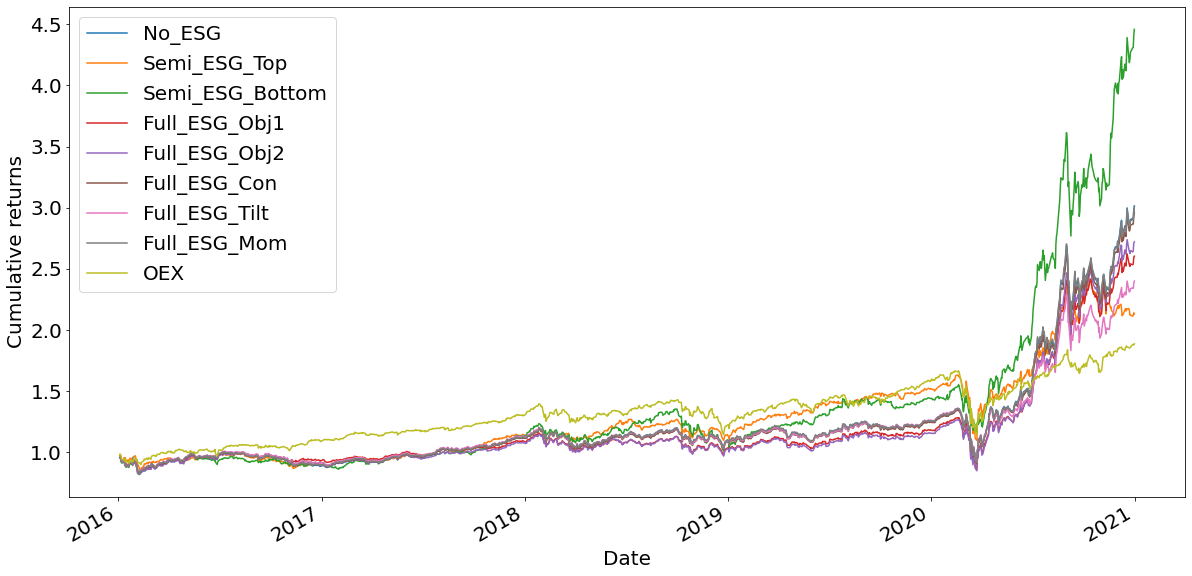

In [20]:
PnL_cumulative.plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative returns", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

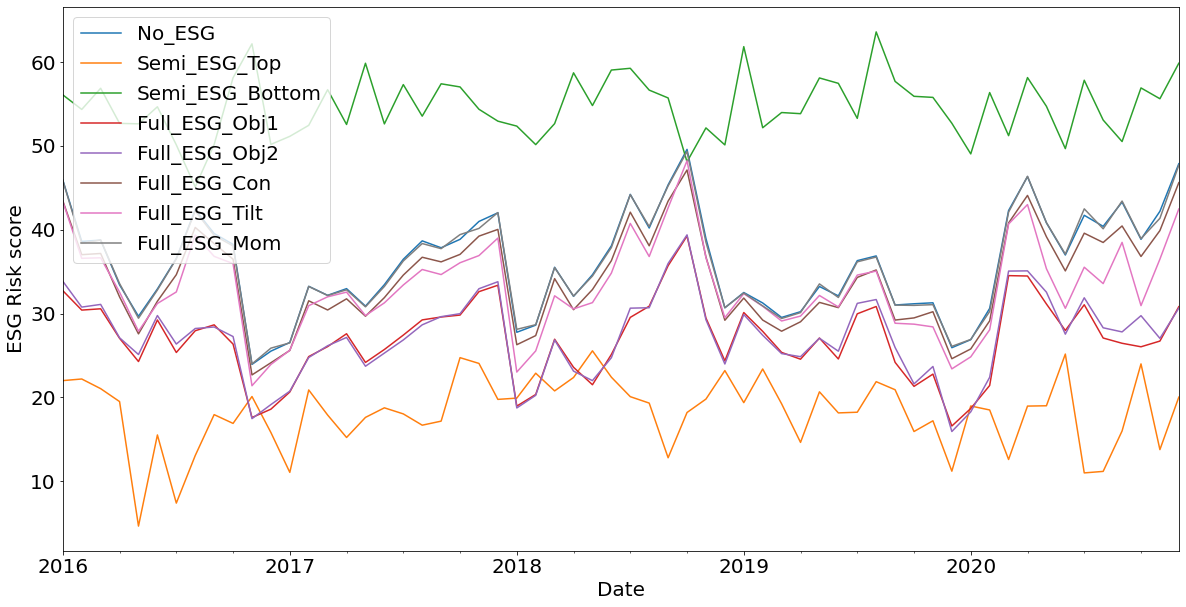

In [21]:
ESG_df.resample('M').mean().dropna().plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("ESG Risk score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

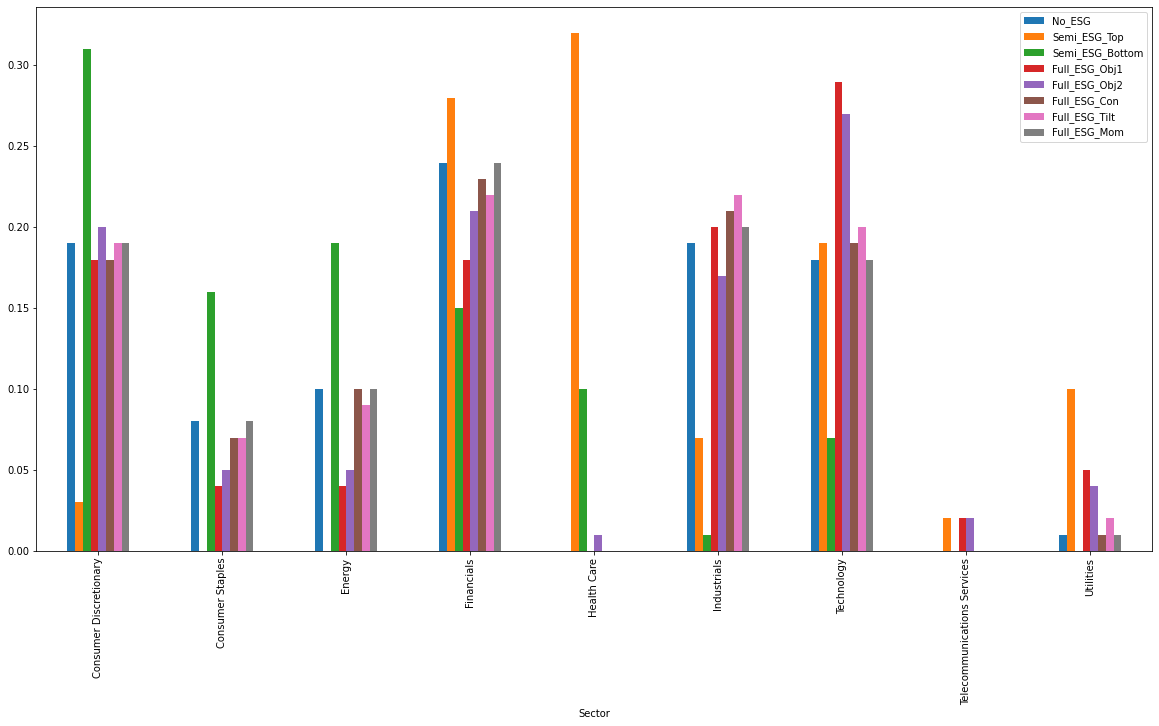

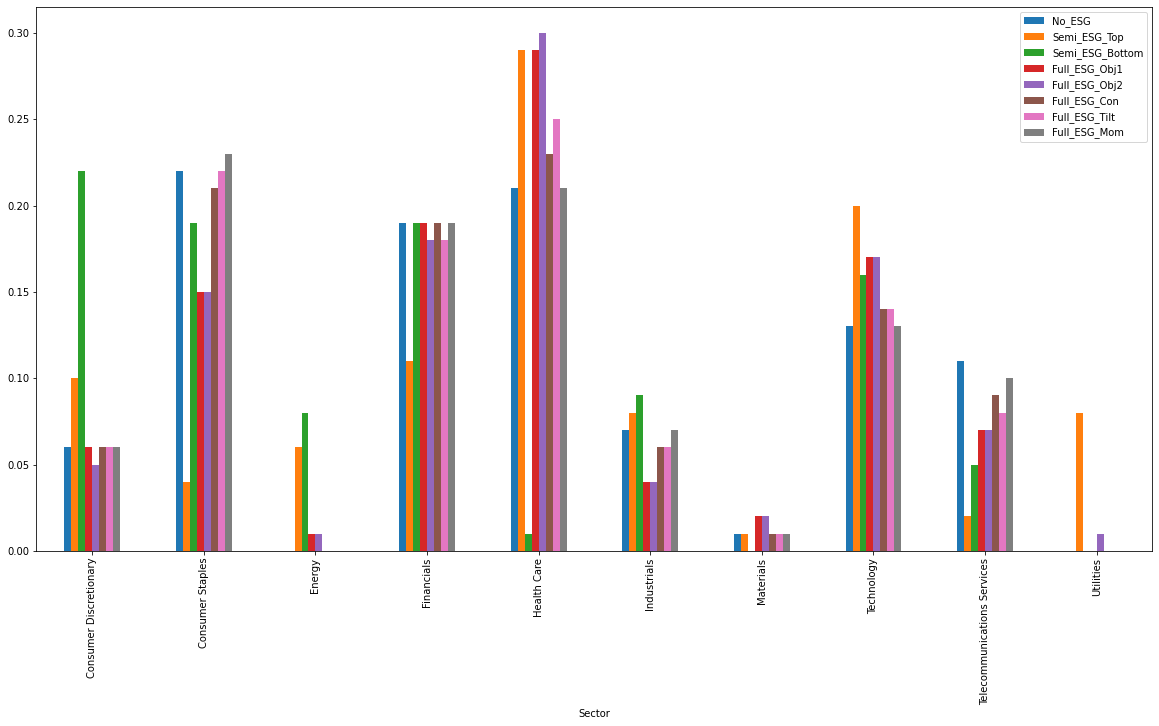

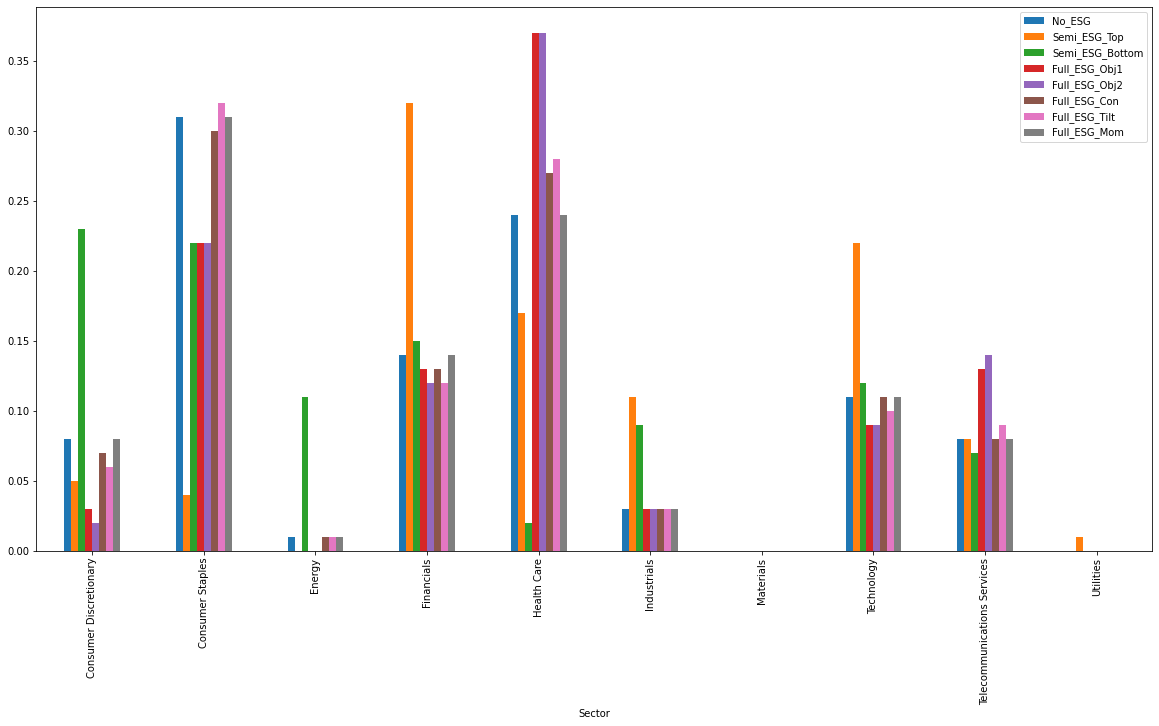

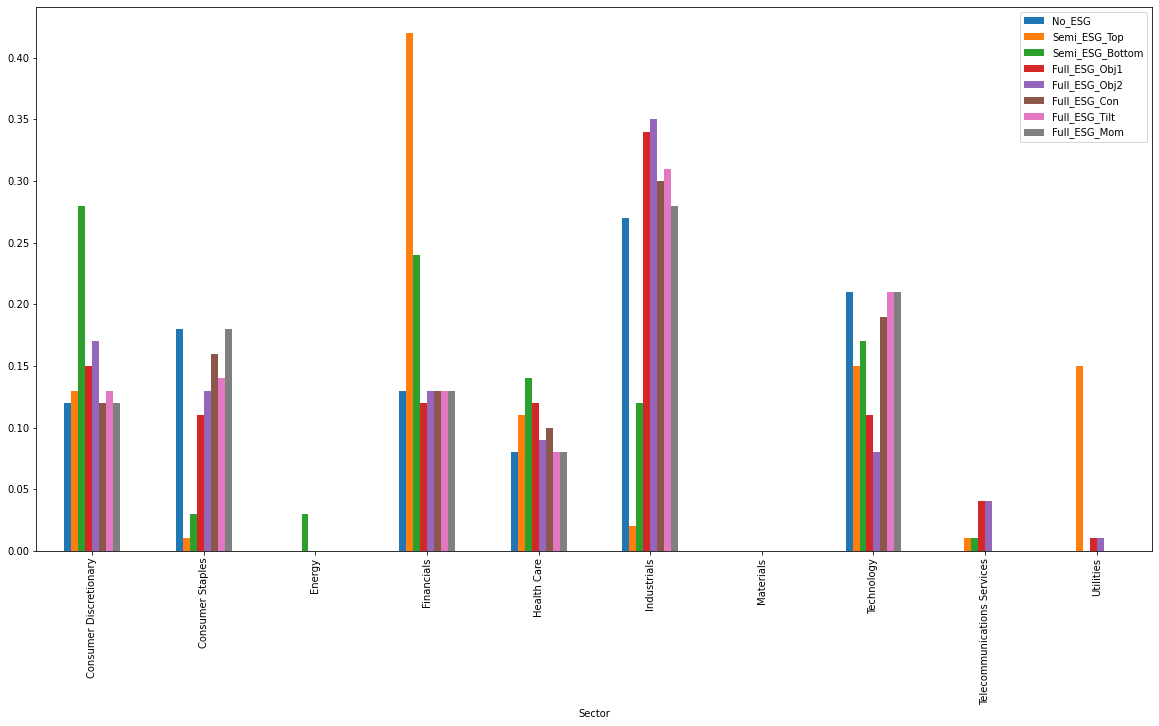

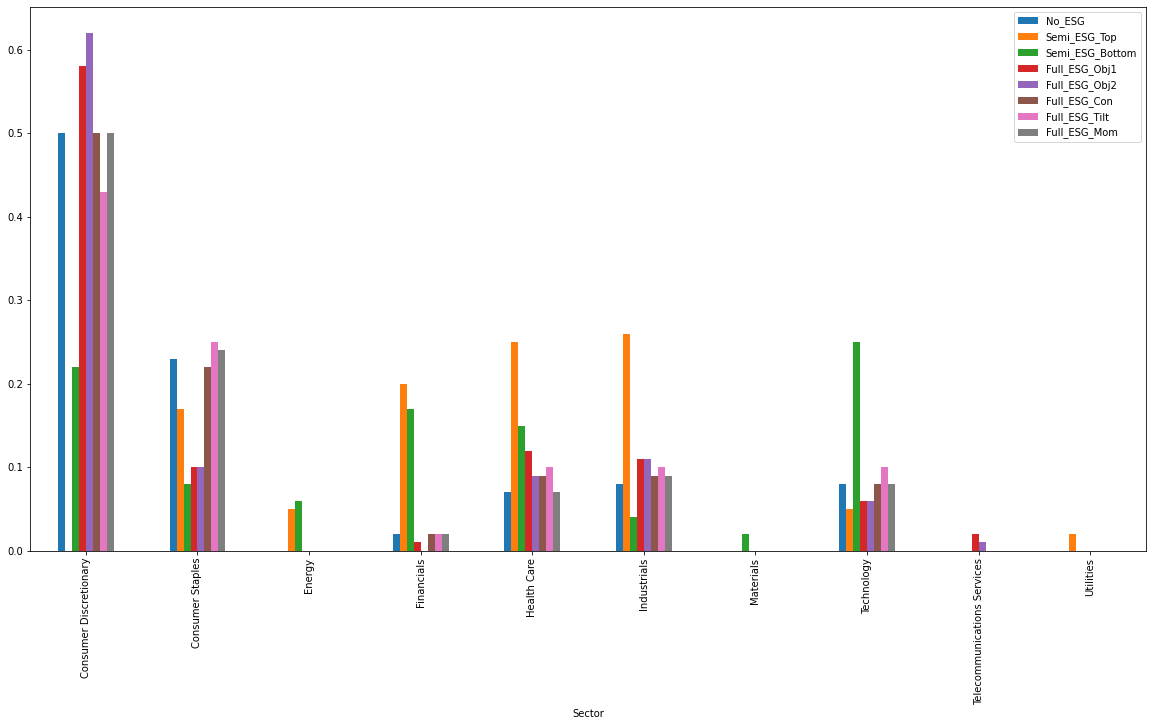

In [22]:
for j in range(5):
  annual = pd.DataFrame(index = main_list[j*12][0].index, columns = ESG_df.columns)
  for i in range(8):
    annual[ESG_df.columns[i]] = np.mean([list(m[i].weights) for m in main_list[j*12:(j+1)*12]], axis=0)
  annual = annual.round(2)
  annual.plot.bar(figsize=(20,10))

In [23]:
# names = list(stats_df.columns)

# # loop over strategies
# for n in range(8):
#   print(names[n])
#   strats = []
#   # loop over sectors
#   for j in range(8):
#     blah = []
#     # loop over timeframe
#     for i in range(len(main_list)):
#       val = main_list[i][n].iloc[j]
#       blah.append(val)
#     strats.append(blah)

#   lab = list(main_list[i][j].index)
#   plt.figure(figsize = (20, 10))
#   for i in range(8):
#     plt.plot(strats[i], label = lab[i])
#   plt.legend()
#   plt.show()

In [24]:
# names = list(main_list[i][j].index) 

# # loop over sectors
# for n in range(8):
#   print(names[n])
#   strats = []
#   # loop over strategies
#   for j in range(8):
#     blah = []
#     # loop over timeframe
#     for i in range(len(main_list)):
#       val = main_list[i][j].iloc[n]
#       blah.append(val)
#     strats.append(blah)

#   lab = list(stats_df.columns)
#   plt.figure(figsize = (20, 10))
#   for i in range(8):
#     plt.plot(strats[i], label = lab[i])
#   plt.legend()
#   plt.show()

## **MARKOWITZ INDEX TRACK**

In [25]:
timeframes = list(point_in_time_monthly.columns)
PnL_df_betas = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_df_betas = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list_betas = []

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []
    
    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_oex_returns = oex_returns[(oex_returns["year"] >= year-1)  & (oex_returns["year"] <= year)]
    sliced_oex_returns1 = sliced_oex_returns[(sliced_oex_returns["year"] == year-1) & (sliced_oex_returns["month"] > month)]
    sliced_oex_returns2 = sliced_oex_returns[(sliced_oex_returns["year"] == year) & (sliced_oex_returns["month"] <= month)]
    sliced_oex_returns = pd.concat([sliced_oex_returns1, sliced_oex_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    # Calculate betas
    betas = []
    for i in sliced_data_returns.columns:
      cov = np.cov(sliced_data_returns[i], sliced_oex_returns['Adj Close'])
      beta = cov[0,1]/cov[1,1]
      betas.append(beta)
    betas = pd.Series(betas, index=sliced_data_returns.columns)
    # strategy 1
    
    no_esg_ret, no_esg_risk, no_esg_weights = markowitz_beta(mu, Sigma, betas)
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret, semi_esg_top_risk, semi_esg_top_weights = markowitz_beta(semi_esg_top_mu, semi_esg_top_Sigma, betas[semi_esg_top_companies])
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_botom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret, semi_esg_bottom_risk, semi_esg_bottom_weights = markowitz_beta(semi_esg_bottom_mu, semi_esg_bottom_Sigma, betas[semi_esg_bottom_companies])
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_botom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_beta_esg(mu, Sigma, 'obj', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_beta_esg(mu, Sigma, 'obj', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_beta_esg(mu, Sigma, 'con', betas, sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_beta_esg(mu, Sigma, 'adj_tilt', betas, sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_beta_esg(mu, Sigma, 'adj_mom', betas, sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_df_betas.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_df_betas.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list_betas.append(sector_list)

  #   break
  # break

2015
2016
2017
2018
2019
2020


In [26]:
PnL_df_betas_final = PnL_df_betas.dropna()
PnL_df_betas_final["OEX"] = oex_returns.loc[PnL_df_betas_final.index,'Adj Close']
PnL_betas_cumulative = (1 + PnL_df_betas_final).cumprod()
PnL_betas_cumulative

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.985269,0.981303,0.985149,0.98569,0.98569,0.985058,0.986244,0.985351,0.983663
2016-01-05,0.987449,0.981485,0.989585,0.991579,0.991579,0.987847,0.988457,0.987662,0.984892
2016-01-06,0.976143,0.971491,0.977803,0.977187,0.977187,0.976835,0.977159,0.976453,0.972955
2016-01-07,0.95374,0.94829,0.955043,0.978486,0.978486,0.954802,0.955191,0.954135,0.948488
2016-01-08,0.944816,0.936621,0.943924,0.965573,0.965573,0.945258,0.945601,0.945126,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,1.859808,1.803005,1.926556,0.841432,0.841432,1.893012,1.855569,1.873813,1.859507
2020-12-28,1.880381,1.809767,1.953754,0.84053,0.84053,1.912396,1.875741,1.894925,1.881889
2020-12-29,1.878682,1.811291,1.948279,0.844474,0.844474,1.909062,1.87416,1.892857,1.879706


In [27]:
stats_df_beta = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df_beta.loc["Ann_Returns_comp", :] = PnL_betas_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_betas_final.mean(axis=0) * 252
ann_vol = PnL_df_betas_final.std(axis=0) * (252)**(0.5)
stats_df_beta.loc["Ann_Vol", :] = ann_vol
stats_df_beta.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_betas_final.sub(PnL_df_betas_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df_beta.loc["Tracking_error", :] = tracking_error
stats_df_beta.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_betas_cumulative - PnL_betas_cumulative.cummax())/ PnL_betas_cumulative.cummax()).min(axis=0)
stats_df_beta.loc["Max_drawdown", :] = mdd
stats_df_beta.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_betas_final[PnL_df_betas_final<0].std(axis=0) * (252)**(0.5)
stats_df_beta.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df_beta.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df_beta.loc["Avg_ESG", :] = ESG_df_betas.mean(axis=0)
stats_df_beta.loc["Sharpe/ESG", :] = stats_df_beta.loc["Ann_Sharpe", :] / ESG_df_betas.mean(axis=0)
stats_df_beta

,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.135068,0.128078,0.14267,-0.033909,-0.033909,0.138266,0.134299,0.136709,0.135498
Ann_Vol,0.18706,0.200921,0.189987,0.284917,0.284917,0.187477,0.187352,0.187054,0.192007
Ann_Sharpe,0.77195,0.701508,0.798047,0.02303,0.02303,0.785671,0.76743,0.779704,0.758968
Tracking_error,0.015286,0.05747,0.034799,0.200823,0.200823,0.017511,0.016456,0.015583,NaN
Information_ratio,-0.086753,-0.083164,0.169291,-0.692978,-0.692978,0.089544,-0.118368,0.007678,NaN
Max_drawdown,-0.317672,-0.392525,-0.334278,-0.48017,-0.48017,-0.315057,-0.31692,-0.318233,-0.315312
Calmar_Ratio,0.454561,0.35908,0.45357,0.013665,0.013665,0.467519,0.453677,0.458302,0.462169
Sortino_ratio,0.854148,0.772341,0.898836,0.027776,0.027776,0.87538,0.849809,0.862728,0.84518
95var,-0.164248,-0.190572,-0.16186,-0.463552,-0.463552,-0.162042,-0.165351,-0.162792,-0.171085
Avg_ESG,32.794651,17.87864,53.925497,3.682308,3.682308,28.379916,29.759573,32.720055,NaN


### **VISUALISATIONS**

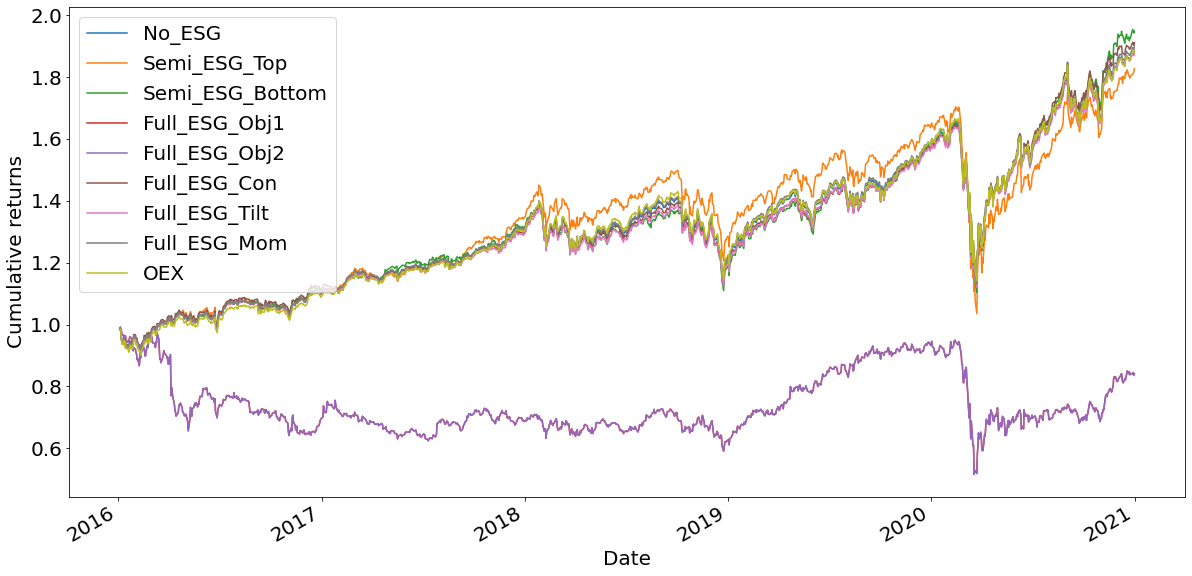

In [28]:
PnL_betas_cumulative.plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("Cumulative returns", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

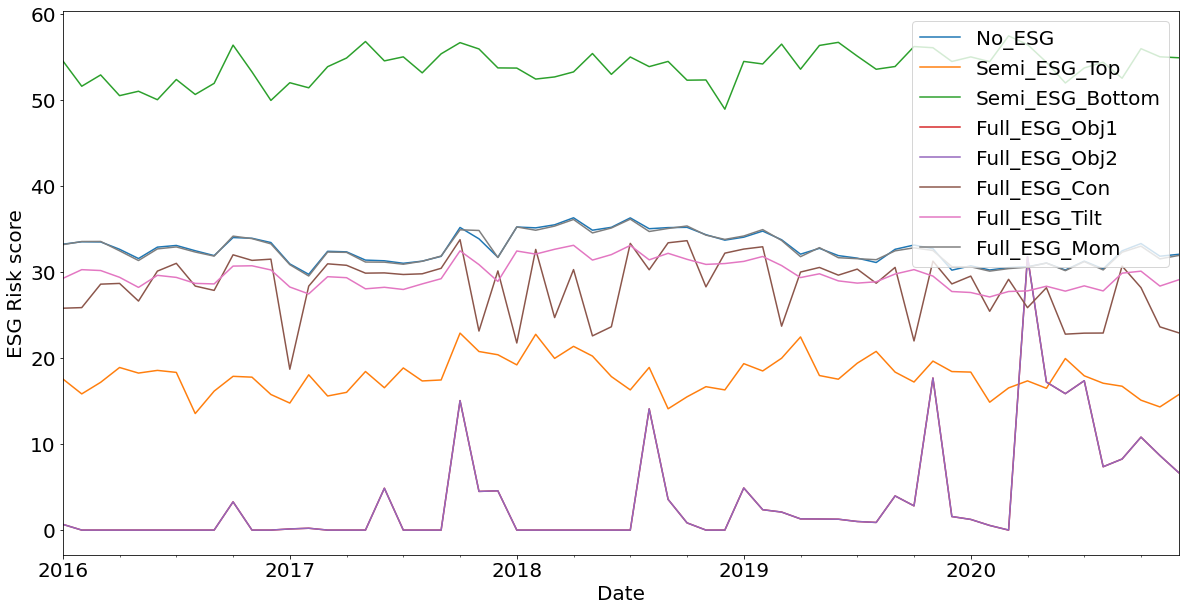

In [29]:
ESG_df_betas.resample('M').mean().dropna().plot(figsize=(20,10))
plt.xlabel("Date", fontsize = 20)
plt.ylabel("ESG Risk score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

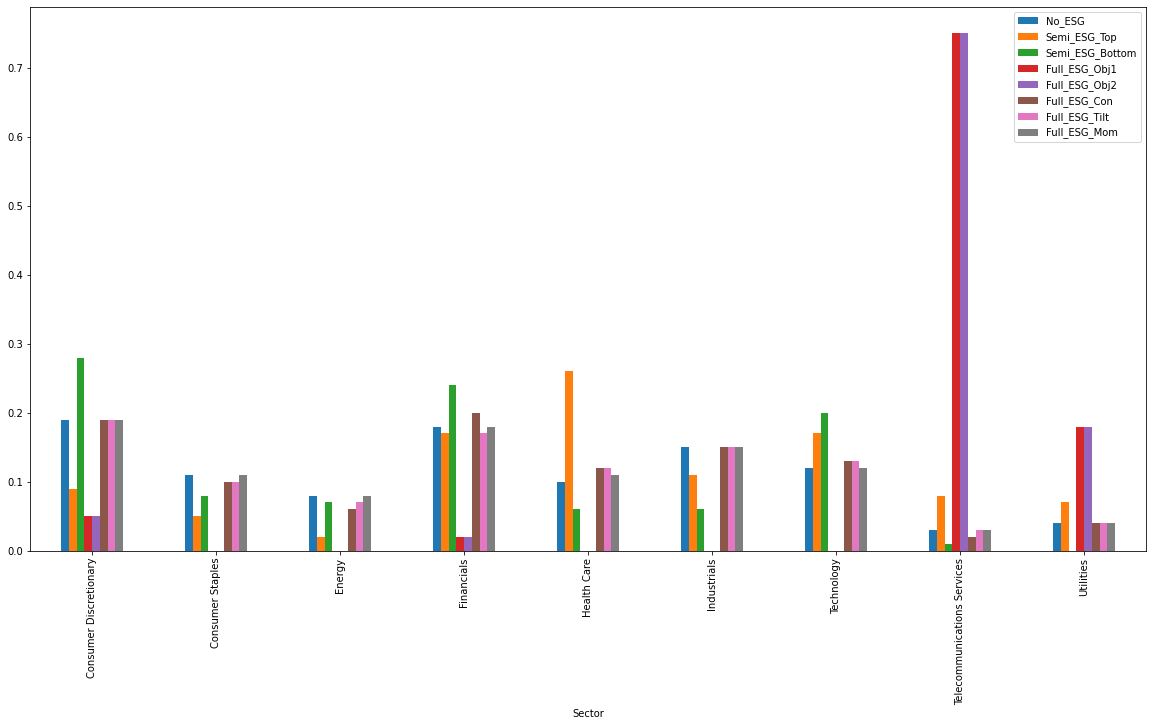

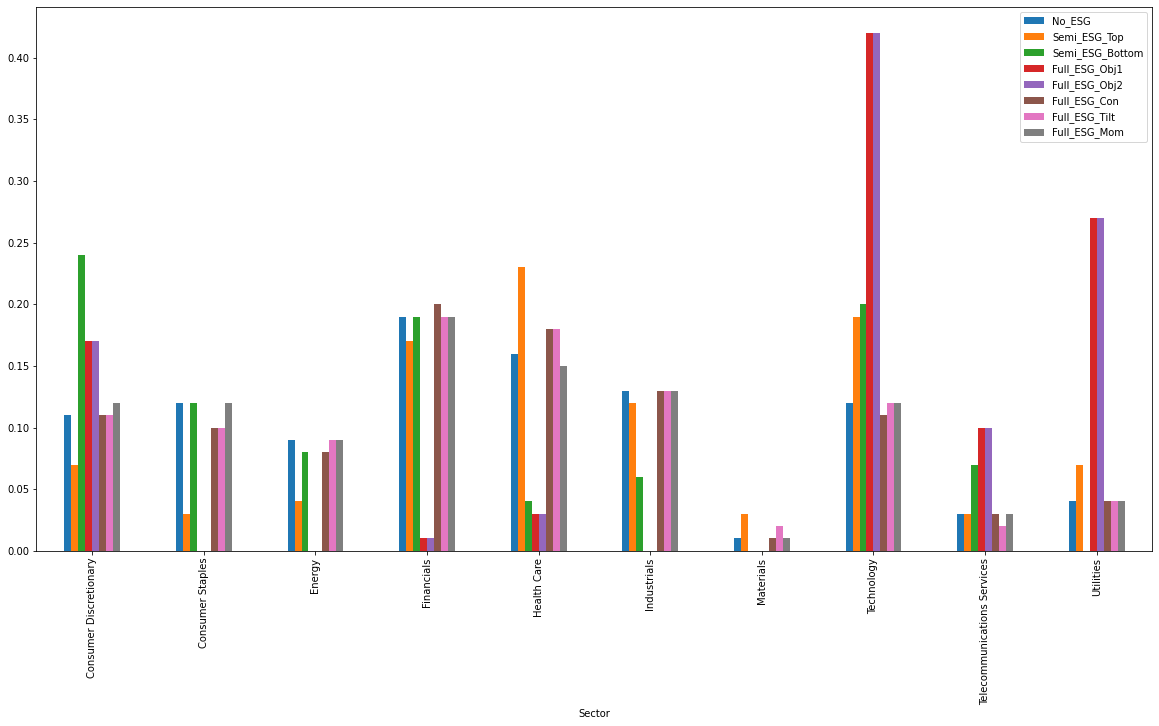

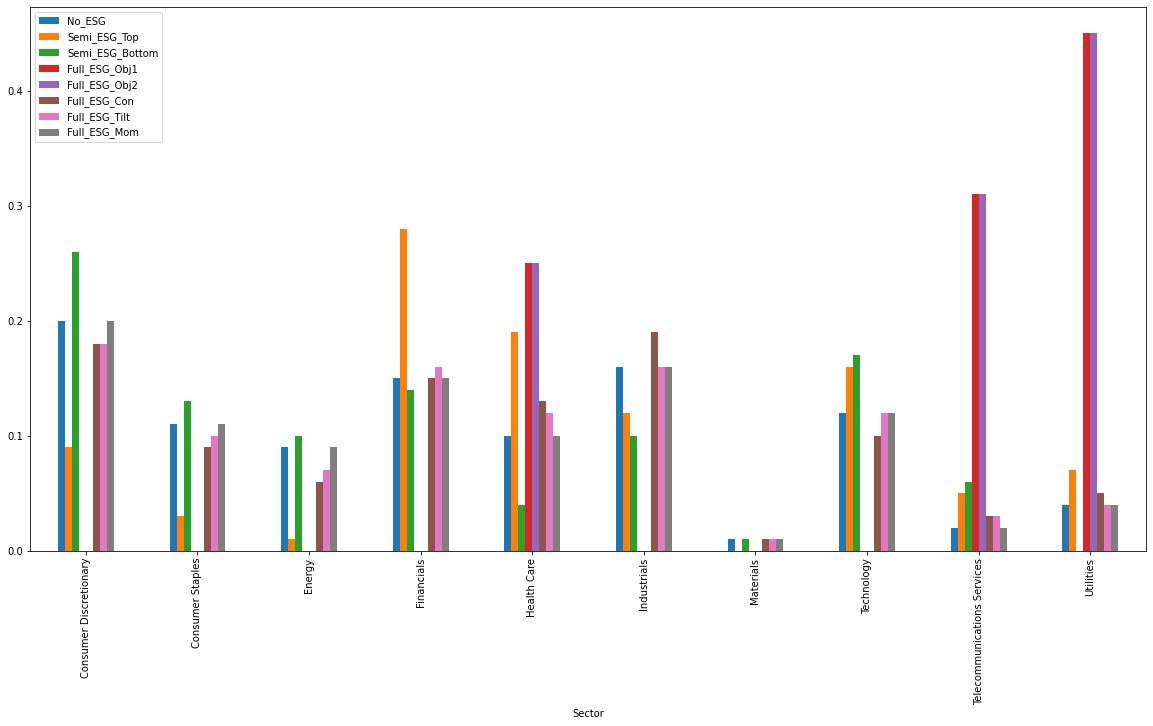

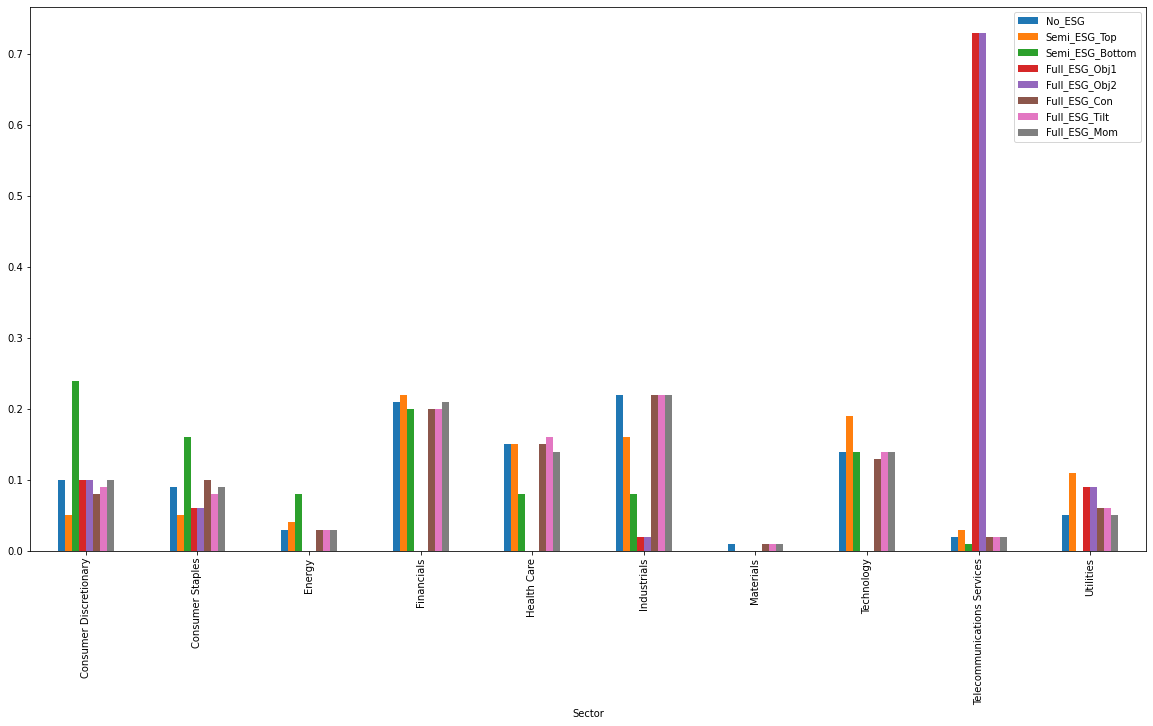

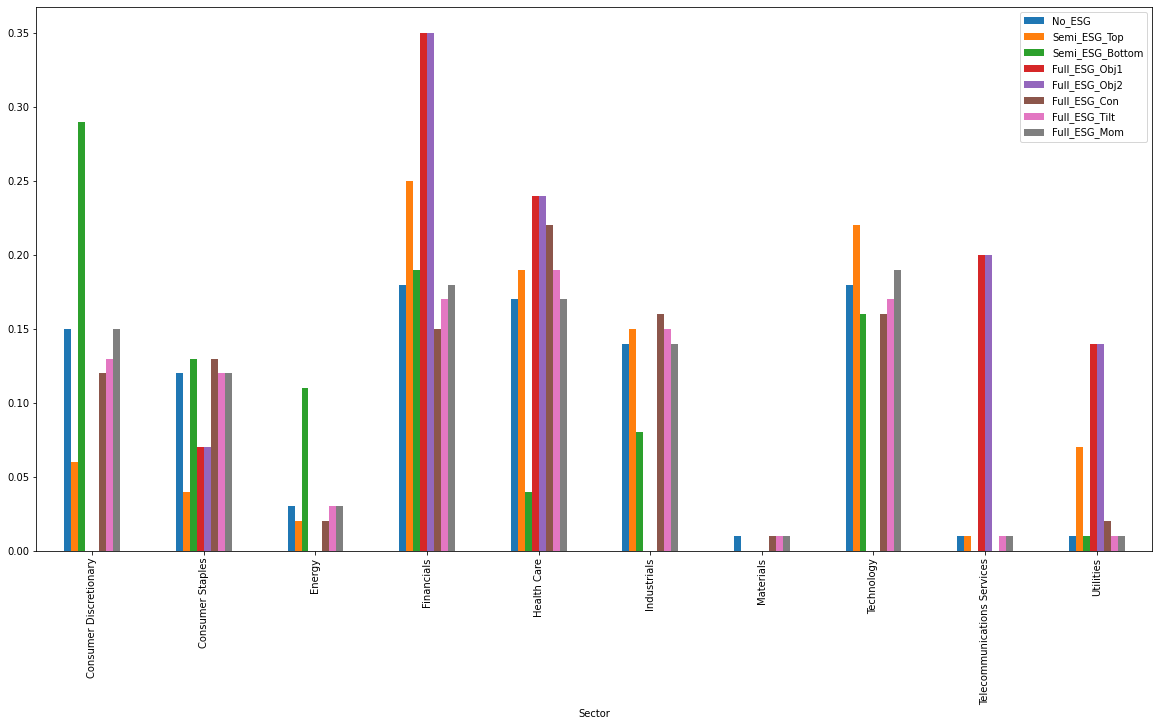

In [30]:
for j in range(5):
  annual = pd.DataFrame(index = main_list_betas[j*12][0].index, columns = ESG_df.columns)
  for i in range(8):
    annual[ESG_df.columns[i]] = np.mean([list(m[i].weights) for m in main_list_betas[j*12:(j+1)*12]], axis=0)
  annual = annual.round(2)
  annual.plot.bar(figsize=(20,10))

In [31]:
# names = list(stats_df_beta.columns)

# # loop over strategies
# for n in range(8):
#   print(names[n])
#   strats = []
#   # loop over sectors
#   for j in range(8):
#     blah = []
#     # loop over timeframe
#     for i in range(len(main_list_betas)):
#       val = main_list_betas[i][n].iloc[j]
#       blah.append(val)
#     strats.append(blah)

#   lab = list(main_list_betas[i][j].index)
#   plt.figure(figsize = (20, 10))
#   for i in range(8):
#     plt.plot(strats[i], label = lab[i])
#   plt.legend()
#   plt.show()

In [32]:
# names = list(main_list_betas[i][j].index) 

# # loop over sectors
# for n in range(8):
#   print(names[n])
#   strats = []
#   # loop over strategies
#   for j in range(8):
#     blah = []
#     # loop over timeframe
#     for i in range(len(main_list_betas)):
#       val = main_list_betas[i][j].iloc[n]
#       blah.append(val)
#     strats.append(blah)

#   lab = list(stats_df_beta.columns)
#   plt.figure(figsize = (20, 10))
#   for i in range(8):
#     plt.plot(strats[i], label = lab[i])
#   plt.legend()
#   plt.show()

# **ADDITIONAL ANALYSIS**

### **PERFORMANCE TRADEOFF**

In [33]:
# year = 2017
# month = 10

# sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
# sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
# sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
# sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)
# sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
# uni_index = timeframes.index(str(year)+'-'+str(month))+1
# univ = list(point_in_time_monthly.iloc[:,uni_index])
# univ_found = [i for i in univ if i in tickers_found]
# sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
# univ_found = list(sliced_data_returns.columns)
# sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
# holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
#                                 (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
# holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
#                                 (esg_data["month"] == int(timeframes[uni_index][5:]))]
# holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
# mu = sliced_data_returns.mean()
# Sigma = sliced_data_returns.cov()

# no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
# no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
# no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
# no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
# no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]

# vary_ret_df = pd.DataFrame(index = ["Returns", "Risk", "Sharpe Ratio", "ESG", "Sharpe/ESG"], 
#                            columns = ["No ESG", "Allow 5% less returns",
#                                       "Allow 10% less returns", "Allow 15% less returns",
#                                       "Allow 20% less returns", "Allow 25% less returns"])
# vary_risk_df = pd.DataFrame(index = ["Returns", "Risk", "Sharpe Ratio", "ESG", "Sharpe/ESG"], 
#                             columns = ["No ESG", "Allow 5% more risk",
#                                        "Allow 10% more risk", "Allow 15% more risk",
#                                        "Allow 20% more risk", "Allow 25% more risk"])

# ret = ((holding_returns * no_esg_weights).sum(axis=1)).mean() * 252
# risk = ((holding_returns * no_esg_weights).sum(axis=1)).std() * (252)**(0.5)
# esg = no_esg_weights @ holding_esg.current_RRI.values
# vary_ret_df["No ESG"] = [ret, risk, ret/risk, esg, ret/(risk*esg)]
# vary_risk_df["No ESG"] = [ret, risk, ret/risk, esg, ret/(risk*esg)]


# for i in range(5, 30, 5):

#   full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
#                                                                               None, no_esg_ret-abs(no_esg_ret)*(i/100), no_esg_risk)
#   full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
#   ret = ((holding_returns * full_esg_obj1_weights).sum(axis=1)).mean() * 252
#   risk = ((holding_returns * full_esg_obj1_weights).sum(axis=1)).std() * (252)**(0.5)
#   esg = full_esg_obj1_weights @ holding_esg.current_RRI.values
#   name = "Allow " + str(i) + "% less returns"
#   vary_ret_df[name] = [ret, risk, ret/risk, esg, ret/(risk*esg)]

#   full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
#                                                                               None, no_esg_ret, no_esg_risk*(1+ i/100))
#   full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
#   ret = ((holding_returns * full_esg_obj2_weights).sum(axis=1)).mean() * 252
#   risk = ((holding_returns * full_esg_obj2_weights).sum(axis=1)).std() * (252)**(0.5)
#   esg = full_esg_obj2_weights @ holding_esg.current_RRI.values
#   name = "Allow " + str(i) + "% more risk"
#   vary_risk_df[name] = [ret, risk, ret/risk, esg, ret/(risk*esg)]

In [34]:
# vary_ret_df = vary_ret_df.round(4)
# vary_ret_df

In [35]:
# vary_risk_df = vary_risk_df.round(4)
# vary_risk_df

In [36]:
timeframes = list(point_in_time_monthly.columns)
PnL_obj1_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% less returns",
                                                                    "Allow 10% less returns", "Allow 15% less returns",
                                                                    "Allow 20% less returns", "Allow 25% less returns"])
ESG_obj1_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% less returns",
                                                                    "Allow 10% less returns", "Allow 15% less returns",
                                                                    "Allow 20% less returns", "Allow 25% less returns"])

PnL_obj2_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% more risk",
                                                                    "Allow 10% more risk", "Allow 15% more risk",
                                                                    "Allow 20% more risk", "Allow 25% more risk"])
ESG_obj2_df = pd.DataFrame(index = price_returns.index, columns = ["No ESG", "Allow 5% more risk",
                                                                    "Allow 10% more risk", "Allow 15% more risk",
                                                                    "Allow 20% more risk", "Allow 25% more risk"])

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
                                    (esg_data["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_obj1_df.loc[holding_returns.index, 'No ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    PnL_obj2_df.loc[holding_returns.index, 'No ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_obj1_df.loc[holding_returns.index, 'No ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    ESG_obj2_df.loc[holding_returns.index, 'No ESG'] = no_esg_weights @ holding_esg.current_RRI.values

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)

    for i in range(5, 30, 5):

      full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                  None, no_esg_ret-abs(no_esg_ret)*(i/100), no_esg_risk)
      full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
      name = "Allow " + str(i) + "% less returns"
      PnL_obj1_df.loc[holding_returns.index, name] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
      ESG_obj1_df.loc[holding_returns.index, name] = full_esg_obj1_weights @ holding_esg.current_RRI.values
      
      full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                  None, no_esg_ret, no_esg_risk*(1+i/100))
      full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
      name = "Allow " + str(i) + "% more risk"
      PnL_obj2_df.loc[holding_returns.index, name] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
      ESG_obj2_df.loc[holding_returns.index, name] = full_esg_obj2_weights @ holding_esg.current_RRI.values

  #   break
  # break

2015
2016
2017
2018
2019
2020


In [37]:
PnL_df_final = PnL_obj1_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No ESG,Allow 5% less returns,Allow 10% less returns,Allow 15% less returns,Allow 20% less returns,Allow 25% less returns,OEX
Date,,,,,,,
2016-01-04,0.957106,0.958196,0.960508,0.962749,0.964959,0.967148,0.983663
2016-01-05,0.958224,0.958313,0.960527,0.962982,0.965547,0.968185,0.984892
2016-01-06,0.953968,0.951975,0.953005,0.95449,0.956176,0.957997,0.972955
2016-01-07,0.921367,0.925236,0.92947,0.933418,0.937244,0.940989,0.948488
2016-01-08,0.917572,0.922274,0.925153,0.928193,0.931308,0.934474,0.938723
...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.540704,2.286971,2.079918,1.864006,1.691424,1.859507
2020-12-28,2.912305,2.533268,2.274334,2.068615,1.853398,1.681007,1.881889
2020-12-29,2.913525,2.539797,2.27998,2.0747,1.859251,1.686432,1.879706


In [38]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_obj1_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_obj1_df.mean(axis=0)
stats_df

,No ESG,Allow 5% less returns,Allow 10% less returns,Allow 15% less returns,Allow 20% less returns,Allow 25% less returns,OEX
Ann_Returns_comp,0.246944,0.210898,0.184594,0.161845,0.136026,0.113453,0.135498
Ann_Vol,0.257422,0.249634,0.246381,0.243094,0.240455,0.238439,0.192007
Ann_Sharpe,0.987548,0.892562,0.811726,0.739476,0.651345,0.570532,0.758968
Tracking_error,0.179676,0.16214,0.154839,0.149169,0.145032,0.142129,NaN
Information_ratio,0.603804,0.475429,0.350471,0.228166,0.075098,-0.068179,NaN
Max_drawdown,-0.323914,-0.330281,-0.331648,-0.334364,-0.338693,-0.340676,-0.315312
Calmar_Ratio,0.784829,0.674618,0.60303,0.537625,0.462421,0.399316,0.462169
Sortino_ratio,1.161544,1.046735,0.962281,0.881696,0.775954,0.680813,0.84518
95var,-0.17053,-0.189082,-0.206535,-0.221343,-0.240131,-0.257388,-0.171085
Avg_ESG,35.979722,26.996765,23.532292,20.961673,18.863478,17.08976,NaN


In [39]:
PnL_df_final = PnL_obj2_df.dropna()
PnL_df_final["OEX"] = oex_returns.loc[PnL_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_df_final).cumprod()
PnL_cumulative

,No ESG,Allow 5% more risk,Allow 10% more risk,Allow 15% more risk,Allow 20% more risk,Allow 25% more risk,OEX
Date,,,,,,,
2016-01-04,0.957106,0.95613,0.956336,0.956361,0.956361,0.956361,0.983663
2016-01-05,0.958224,0.955266,0.954568,0.954484,0.954484,0.954484,0.984892
2016-01-06,0.953968,0.949352,0.948024,0.947865,0.947865,0.947865,0.972955
2016-01-07,0.921367,0.92201,0.922845,0.922945,0.922945,0.922945,0.948488
2016-01-08,0.917572,0.918823,0.918344,0.918287,0.918287,0.918287,0.938723
...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.650429,2.516592,2.438222,2.363807,2.337065,1.859507
2020-12-28,2.912305,2.638278,2.508838,2.430709,2.356524,2.329864,1.881889
2020-12-29,2.913525,2.644474,2.517367,2.438972,2.364535,2.337784,1.879706


In [40]:
stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_df_final.mean(axis=0) * 252
ann_vol = PnL_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_df_final.sub(PnL_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_df_final[PnL_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_obj2_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_obj2_df.mean(axis=0)
stats_df

,No ESG,Allow 5% more risk,Allow 10% more risk,Allow 15% more risk,Allow 20% more risk,Allow 25% more risk,OEX
Ann_Returns_comp,0.246944,0.221615,0.209756,0.202126,0.194697,0.191981,0.135498
Ann_Vol,0.257422,0.259072,0.264571,0.270235,0.275588,0.280241,0.192007
Ann_Sharpe,0.987548,0.9034,0.853158,0.817385,0.784242,0.767692,0.758968
Tracking_error,0.179676,0.171355,0.172372,0.174674,0.177933,0.180712,NaN
Information_ratio,0.603804,0.515413,0.464075,0.43028,0.395657,0.384098,NaN
Max_drawdown,-0.323914,-0.329791,-0.330945,-0.332081,-0.331464,-0.325603,-0.315312
Calmar_Ratio,0.784829,0.70968,0.68205,0.665157,0.652041,0.660739,0.462169
Sortino_ratio,1.161544,1.070513,1.025814,0.990326,0.955155,0.938669,0.84518
95var,-0.17053,-0.193423,-0.210822,-0.225002,-0.238593,-0.247259,-0.171085
Avg_ESG,35.979722,27.313682,24.597851,22.989571,21.858983,21.044804,NaN


### **E, S, G PORTFOLIOS**

2015
2016
2017
2018
2019
2020


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.957106,0.976928,0.992011,0.960165,0.957986,0.957822,0.957427,0.958477,0.983663
2016-01-05,0.958224,0.98176,1.001179,0.958256,0.955905,0.958894,0.958644,0.960174,0.984892
2016-01-06,0.953968,0.981077,0.991659,0.952793,0.951493,0.954557,0.954368,0.95571,0.972955
2016-01-07,0.921367,0.942367,0.963407,0.917437,0.916969,0.921608,0.921768,0.923513,0.948488
2016-01-08,0.917572,0.935286,0.956195,0.910043,0.91036,0.917468,0.917874,0.919502,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,2.903513,1.249466,3.425975,3.028694,3.330694,2.80721,2.90823,2.893707,1.859507
2020-12-28,2.912305,1.24448,3.440205,3.022715,3.322808,2.816545,2.917422,2.902423,1.881889
2020-12-29,2.913525,1.234655,3.439999,3.022939,3.326124,2.817549,2.918292,2.903484,1.879706


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.246944,0.044786,0.291219,0.255059,0.279646,0.238632,0.247087,0.246016,0.135498
Ann_Vol,0.257422,0.219155,0.273198,0.251291,0.262043,0.254687,0.255724,0.258165,0.192007
Ann_Sharpe,0.987548,0.310188,1.073432,1.031093,1.073407,0.969182,0.992844,0.982561,0.758968
Tracking_error,0.179676,0.131986,0.209625,0.166928,0.176938,0.175831,0.177392,0.180417,NaN
Information_ratio,0.603804,-0.589062,0.703791,0.679196,0.766098,0.575046,0.609763,0.598257,NaN
Max_drawdown,-0.323914,-0.376788,-0.319724,-0.328808,-0.331966,-0.324282,-0.324497,-0.32486,-0.315312
Calmar_Ratio,0.784829,0.180418,0.917227,0.78801,0.847312,0.761186,0.782425,0.780837,0.462169
Sortino_ratio,1.161544,0.365348,1.291778,1.22355,1.289148,1.129937,1.16378,1.154835,0.84518
95var,-0.17053,-0.293627,-0.157517,-0.155526,-0.151092,-0.173396,-0.168051,-0.172309,-0.171085
Avg_ESG,5.113352,0.084679,13.447754,2.108621,2.215271,4.861727,4.80379,5.094712,NaN


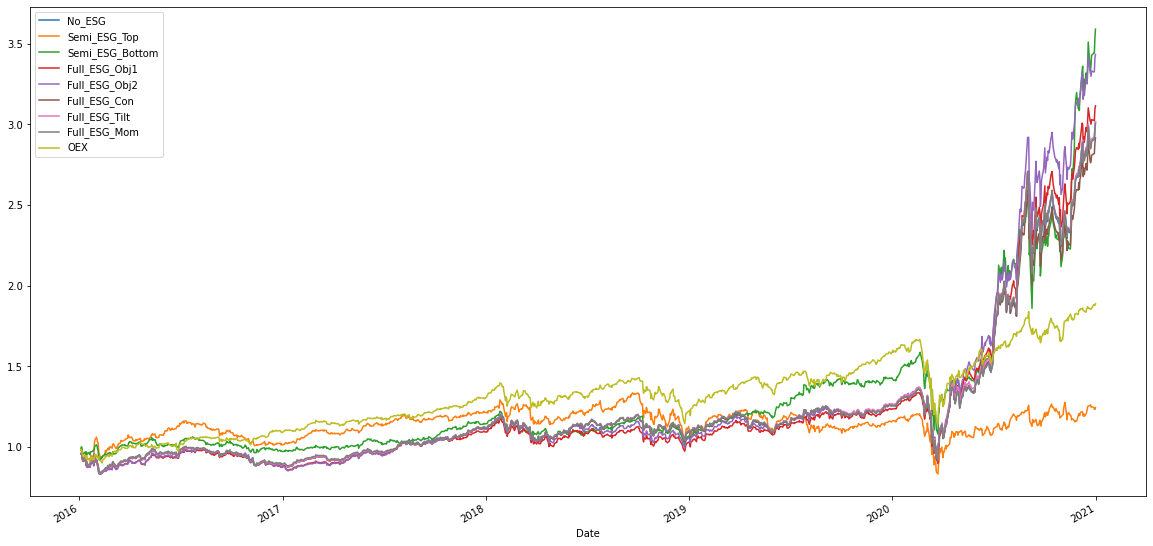

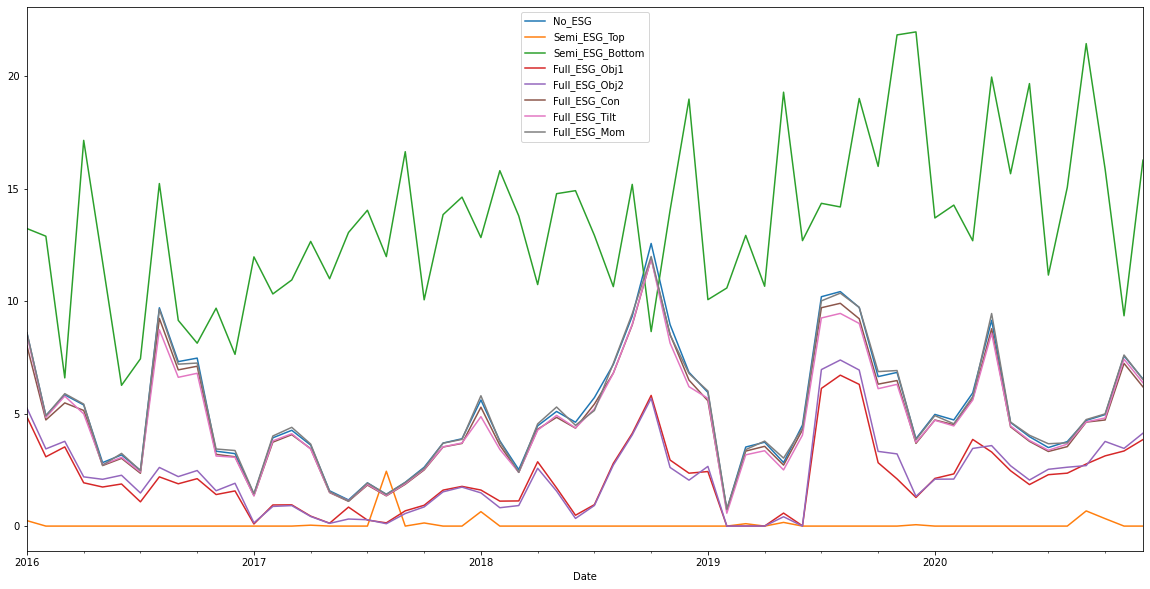

In [41]:
timeframes = list(point_in_time_monthly.columns)
PnL_E_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_E_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list = []

e_obj1 = []
e_cons = []

tmp_ESG = esg_data.copy()
tmp_ESG.current_RRI = tmp_ESG.current_RRI * tmp_ESG.environmental_percentage.str[:-1].astype(int)/100

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = tmp_ESG[(tmp_ESG["year"] == year) & (tmp_ESG["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = tmp_ESG[(tmp_ESG["year"] == int(timeframes[uni_index][:4])) & 
                                    (tmp_ESG["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret_data, semi_esg_top_risk_data, semi_esg_top_w_data = markowitz(semi_esg_top_mu, semi_esg_top_Sigma)
    semi_esg_top_sharpe_data = semi_esg_top_ret_data / semi_esg_top_risk_data
    semi_esg_top_ret = semi_esg_top_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_risk = semi_esg_top_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_weights = semi_esg_top_w_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret_data, semi_esg_bottom_risk_data, semi_esg_bottom_w_data = markowitz(semi_esg_bottom_mu, semi_esg_bottom_Sigma)
    semi_esg_bottom_sharpe_data = semi_esg_bottom_ret_data / semi_esg_bottom_risk_data
    semi_esg_bottom_ret = semi_esg_bottom_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_risk = semi_esg_bottom_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_weights = semi_esg_bottom_w_data[np.argmax(semi_esg_bottom_sharpe_data)]
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_bottom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_esg(mu, Sigma, 'con', sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_esg(mu, Sigma, 'adj_tilt', sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_esg(mu, Sigma, 'adj_mom', sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_E_df.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_E_df.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list.append(sector_list)

    e_obj1.append(full_esg_obj1_weights)
    e_cons.append(full_esg_con_weights)

  #   break
  # break

PnL_E_df_final = PnL_E_df.dropna()
PnL_E_df_final["OEX"] = oex_returns.loc[PnL_E_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_E_df_final).cumprod()
display(PnL_cumulative)

stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_E_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_E_df_final.mean(axis=0) * 252
ann_vol = PnL_E_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_E_df_final.sub(PnL_E_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_E_df_final[PnL_E_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_E_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_E_df.mean(axis=0)
display(stats_df)

PnL_cumulative.plot(figsize=(20,10))
plt.show()

ESG_E_df.resample('M').mean().dropna().plot(figsize=(20,10))
plt.show()

In [42]:
# for j in range(5):
#   annual = pd.DataFrame(index = main_list[j*12][0].index, columns = ESG_E_df.columns)
#   for i in range(8):
#     annual[ESG_E_df.columns[i]] = np.mean([list(m[i].weights) for m in main_list[j*12:(j+1)*12]], axis=0)
#   annual = annual.round(2)
#   annual.plot.bar(figsize=(20,10))

2015
2016
2017
2018
2019
2020


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.957106,0.977858,0.958268,0.959497,0.957183,0.957044,0.956587,0.958477,0.983663
2016-01-05,0.958224,0.983905,0.958045,0.956937,0.954323,0.957652,0.957313,0.960174,0.984892
2016-01-06,0.953968,0.977904,0.952509,0.949903,0.948028,0.953161,0.953112,0.95571,0.972955
2016-01-07,0.921367,0.953498,0.918516,0.911579,0.909943,0.920283,0.920295,0.923513,0.948488
2016-01-08,0.917572,0.945833,0.913061,0.904353,0.90353,0.916406,0.916739,0.919502,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,2.903513,1.283478,4.227299,2.784218,2.987018,2.878092,2.488045,2.893707,1.859507
2020-12-28,2.912305,1.277656,4.243325,2.783423,2.981628,2.887951,2.495346,2.902423,1.881889
2020-12-29,2.913525,1.281181,4.240995,2.79097,2.990146,2.888769,2.494487,2.903484,1.879706


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.246944,0.05211,0.343945,0.234193,0.251981,0.24455,0.207615,0.246016,0.135498
Ann_Vol,0.257422,0.213279,0.271635,0.250131,0.26059,0.254238,0.245702,0.258165,0.192007
Ann_Sharpe,0.987548,0.34538,1.225829,0.967555,0.993979,0.989107,0.892038,0.982561,0.758968
Tracking_error,0.179676,0.132446,0.187348,0.161581,0.171846,0.174975,0.164636,0.180417,NaN
Information_ratio,0.603804,-0.544107,0.999484,0.595911,0.65927,0.604322,0.446124,0.598257,NaN
Max_drawdown,-0.323914,-0.347869,-0.286171,-0.323808,-0.324133,-0.32436,-0.324104,-0.32486,-0.315312
Calmar_Ratio,0.784829,0.211753,1.163562,0.747405,0.799117,0.775277,0.67625,0.780837,0.462169
Sortino_ratio,1.161544,0.402182,1.504179,1.146048,1.188198,1.162301,1.038963,1.154835,0.84518
95var,-0.17053,-0.278248,-0.11522,-0.170701,-0.170952,-0.168024,-0.186232,-0.172309,-0.171085
Avg_ESG,15.093181,3.258147,25.399083,9.334506,9.57435,14.346971,14.013673,15.067462,NaN


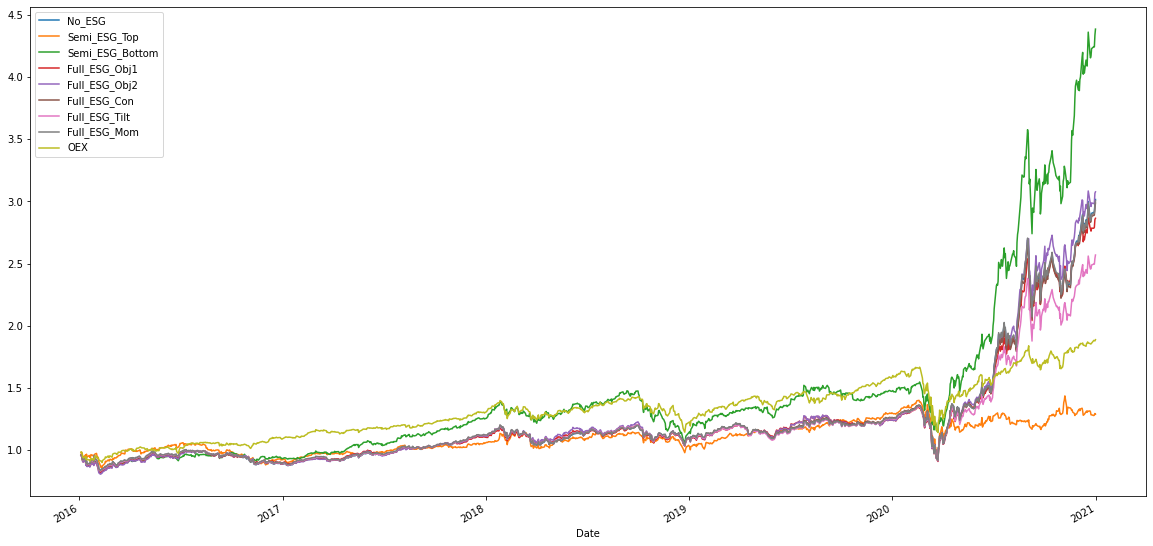

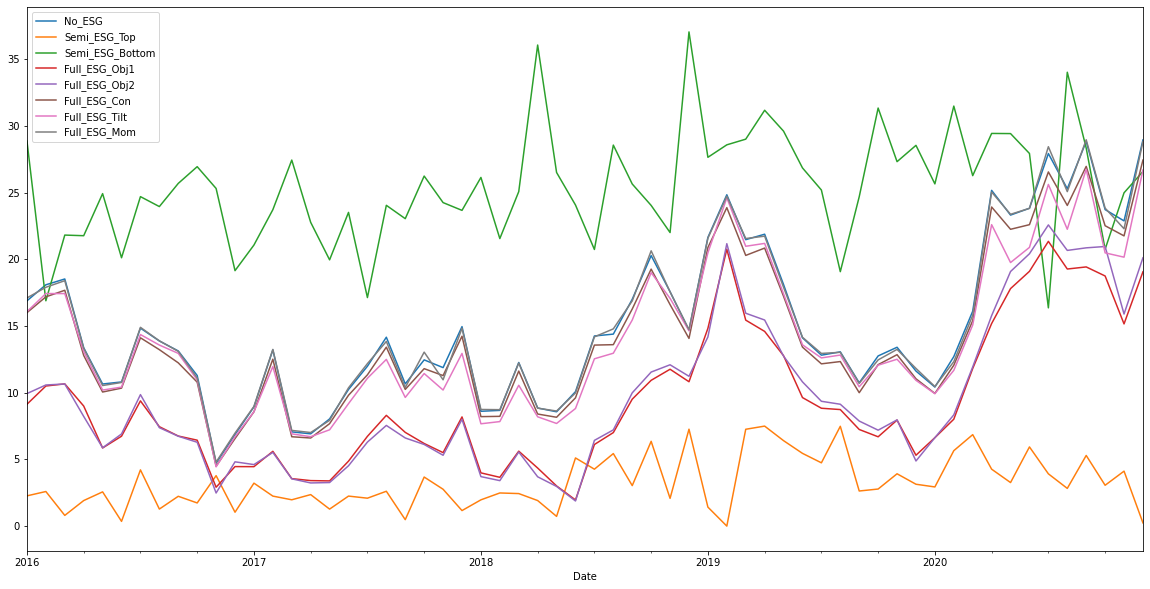

In [43]:
timeframes = list(point_in_time_monthly.columns)
PnL_S_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_S_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list = []

s_obj1 = []
s_cons = []

tmp_ESG = esg_data.copy()
tmp_ESG.current_RRI = tmp_ESG.current_RRI * tmp_ESG.social_percentage.str[:-1].astype(int)/100

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = tmp_ESG[(tmp_ESG["year"] == year) & (tmp_ESG["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = tmp_ESG[(tmp_ESG["year"] == int(timeframes[uni_index][:4])) & 
                                    (tmp_ESG["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret_data, semi_esg_top_risk_data, semi_esg_top_w_data = markowitz(semi_esg_top_mu, semi_esg_top_Sigma)
    semi_esg_top_sharpe_data = semi_esg_top_ret_data / semi_esg_top_risk_data
    semi_esg_top_ret = semi_esg_top_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_risk = semi_esg_top_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_weights = semi_esg_top_w_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret_data, semi_esg_bottom_risk_data, semi_esg_bottom_w_data = markowitz(semi_esg_bottom_mu, semi_esg_bottom_Sigma)
    semi_esg_bottom_sharpe_data = semi_esg_bottom_ret_data / semi_esg_bottom_risk_data
    semi_esg_bottom_ret = semi_esg_bottom_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_risk = semi_esg_bottom_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_weights = semi_esg_bottom_w_data[np.argmax(semi_esg_bottom_sharpe_data)]
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_bottom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_esg(mu, Sigma, 'con', sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_esg(mu, Sigma, 'adj_tilt', sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_esg(mu, Sigma, 'adj_mom', sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_S_df.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_S_df.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list.append(sector_list)

    s_obj1.append(full_esg_obj1_weights)
    s_cons.append(full_esg_con_weights)

  #   break
  # break

PnL_S_df_final = PnL_S_df.dropna()
PnL_S_df_final["OEX"] = oex_returns.loc[PnL_S_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_S_df_final).cumprod()
display(PnL_cumulative)

stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_S_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_S_df_final.mean(axis=0) * 252
ann_vol = PnL_S_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_S_df_final.sub(PnL_S_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_S_df_final[PnL_S_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_S_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_S_df.mean(axis=0)
display(stats_df)

PnL_cumulative.plot(figsize=(20,10))
plt.show()

ESG_S_df.resample('M').mean().dropna().plot(figsize=(20,10))
plt.show()

In [44]:
# for j in range(5):
#   annual = pd.DataFrame(index = main_list[j*12][0].index, columns = ESG_S_df.columns)
#   for i in range(8):
#     annual[ESG_S_df.columns[i]] = np.mean([list(m[i].weights) for m in main_list[j*12:(j+1)*12]], axis=0)
#   annual = annual.round(2)
#   annual.plot.bar(figsize=(20,10))

2015
2016
2017
2018
2019
2020


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Date,,,,,,,,,
2016-01-04,0.957106,0.989345,0.950978,0.95791,0.955812,0.957325,0.958338,0.958477,0.983663
2016-01-05,0.958224,0.985869,0.949588,0.959282,0.956343,0.958379,0.959914,0.960174,0.984892
2016-01-06,0.953968,0.976611,0.94584,0.953821,0.951404,0.95369,0.955173,0.95571,0.972955
2016-01-07,0.921367,0.948755,0.912994,0.924068,0.920709,0.921245,0.923017,0.923513,0.948488
2016-01-08,0.917572,0.937645,0.911781,0.922928,0.919547,0.917571,0.919041,0.919502,0.938723
...,...,...,...,...,...,...,...,...,...
2020-12-24,2.903513,2.036368,3.135994,2.401271,2.533799,2.897815,2.865832,2.893707,1.859507
2020-12-28,2.912305,2.021676,3.153984,2.385144,2.522183,2.906507,2.873731,2.902423,1.881889
2020-12-29,2.913525,2.028454,3.15527,2.388135,2.528106,2.907329,2.874376,2.903484,1.879706


,No_ESG,Semi_ESG_Top,Semi_ESG_Bottom,Full_ESG_Obj1,Full_ESG_Obj2,Full_ESG_Con,Full_ESG_Tilt,Full_ESG_Mom,OEX
Ann_Returns_comp,0.246944,0.153931,0.2684,0.196162,0.210669,0.246344,0.243576,0.246016,0.135498
Ann_Vol,0.257422,0.25203,0.297308,0.247129,0.256474,0.257131,0.25601,0.258165,0.192007
Ann_Sharpe,0.987548,0.694784,0.949946,0.84953,0.874845,0.986487,0.981005,0.982561,0.758968
Tracking_error,0.179676,0.165001,0.206626,0.162916,0.171657,0.179574,0.178197,0.180417,NaN
Information_ratio,0.603804,0.178056,0.661578,0.394166,0.458169,0.601029,0.591589,0.598257,NaN
Max_drawdown,-0.323914,-0.337813,-0.312162,-0.330293,-0.33074,-0.325867,-0.323514,-0.32486,-0.315312
Calmar_Ratio,0.784829,0.518354,0.904744,0.635627,0.678403,0.778405,0.776309,0.780837,0.462169
Sortino_ratio,1.161544,0.826032,1.154979,0.991091,1.032279,1.157436,1.149044,1.154835,0.84518
95var,-0.17053,-0.240743,-0.208132,-0.197819,-0.198807,-0.17061,-0.171269,-0.172309,-0.171085
Avg_ESG,15.773189,3.510299,28.865984,10.01155,10.211645,15.007865,14.984227,15.74572,NaN


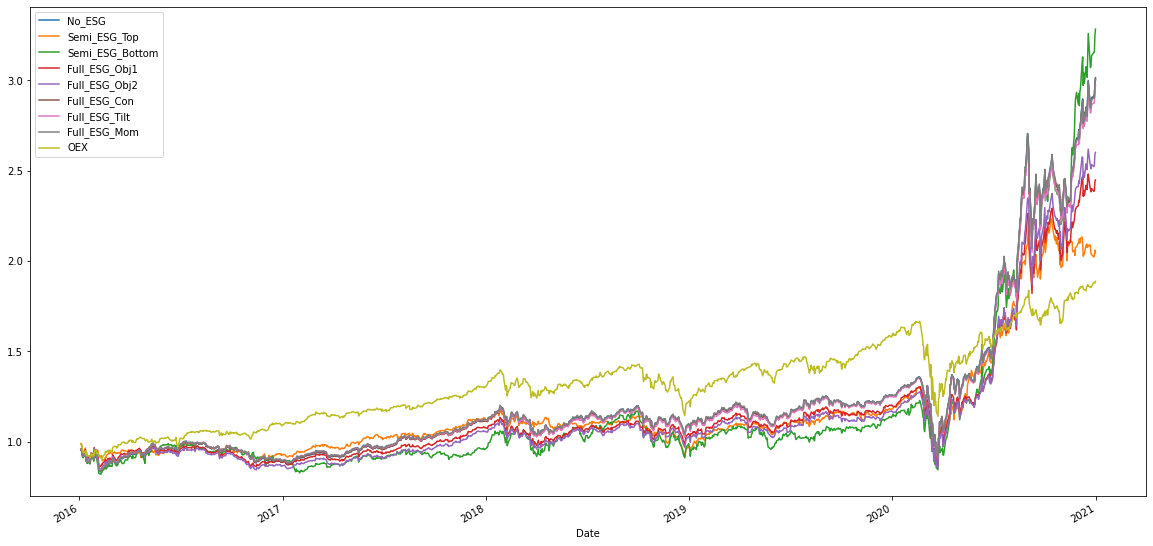

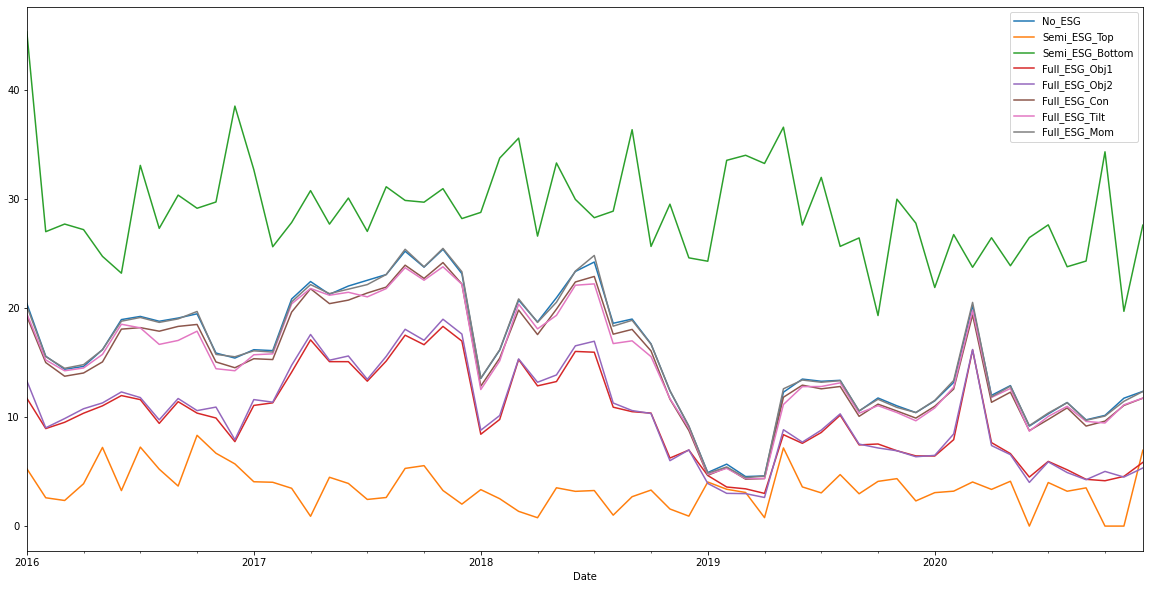

In [45]:
timeframes = list(point_in_time_monthly.columns)
PnL_G_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
ESG_G_df = pd.DataFrame(index = price_returns.index, columns = ["No_ESG", "Semi_ESG_Top", "Semi_ESG_Bottom",
                                                              "Full_ESG_Obj1", "Full_ESG_Obj2",
                                                              "Full_ESG_Con", "Full_ESG_Tilt", "Full_ESG_Mom"])
main_list = []

g_obj1 = []
g_cons = []

tmp_ESG = esg_data.copy()
tmp_ESG.current_RRI = tmp_ESG.current_RRI * tmp_ESG.governance_percentage.str[:-1].astype(int)/100

for year in range (2015, 2021):
  for month in range(1, 13):

    if(month == 1): print(year)
    if year == 2015 and month != 12: continue
    if year == 2020 and month == 12: break

    sector_list = []

    # filter data for universe in current time frame
    sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
    sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
    sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
    sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

    sliced_data_esg = tmp_ESG[(tmp_ESG["year"] == year) & (tmp_ESG["month"] == month)]
    uni_index = timeframes.index(str(year)+'-'+str(month))+1
    univ = list(point_in_time_monthly.iloc[:,uni_index])
    univ_found = [i for i in univ if i in tickers_found]
    sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
    univ_found = list(sliced_data_returns.columns)
    sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
    holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
                                    (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
    holding_esg = tmp_ESG[(tmp_ESG["year"] == int(timeframes[uni_index][:4])) & 
                                    (tmp_ESG["month"] == int(timeframes[uni_index][5:]))]
    holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    sector_df = holding_esg[["Ticker", "Sector"]]
    mu = sliced_data_returns.mean()
    Sigma = sliced_data_returns.cov()
    
    # strategy 1
    
    no_esg_ret_data, no_esg_risk_data, no_esg_w_data = markowitz(mu, Sigma)
    no_esg_sharpe_data = no_esg_ret_data / no_esg_risk_data
    no_esg_ret = no_esg_ret_data[np.argmax(no_esg_sharpe_data)]
    no_esg_risk = no_esg_risk_data[np.argmax(no_esg_sharpe_data)]
    no_esg_weights = no_esg_w_data[np.argmax(no_esg_sharpe_data)]
    no_esg_score = no_esg_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'No_ESG'] = (holding_returns * no_esg_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'No_ESG'] = no_esg_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = no_esg_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 2
    
    semi_esg_top_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[:25].Ticker.values)
    semi_esg_top_sliced_data_returns = sliced_data_returns[semi_esg_top_companies]
    semi_esg_top_holding_returns = holding_returns[semi_esg_top_companies]
    semi_esg_top_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_top_companies)]
    semi_esg_top_mu = semi_esg_top_sliced_data_returns.mean()
    semi_esg_top_Sigma = semi_esg_top_sliced_data_returns.cov()
    semi_esg_top_ret_data, semi_esg_top_risk_data, semi_esg_top_w_data = markowitz(semi_esg_top_mu, semi_esg_top_Sigma)
    semi_esg_top_sharpe_data = semi_esg_top_ret_data / semi_esg_top_risk_data
    semi_esg_top_ret = semi_esg_top_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_risk = semi_esg_top_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_weights = semi_esg_top_w_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_top_score = semi_esg_top_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_top_companies)].current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Semi_ESG_Top'] = (semi_esg_top_holding_returns * semi_esg_top_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Semi_ESG_Top'] = semi_esg_top_weights @ semi_esg_top_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_top_companies), "weights"] = semi_esg_top_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    semi_esg_bottom_companies = list(sliced_data_esg.sort_values(by="current_RRI").iloc[-25:].Ticker.values)
    semi_esg_bottom_sliced_data_returns = sliced_data_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_returns = holding_returns[semi_esg_bottom_companies]
    semi_esg_bottom_holding_esg = holding_esg[holding_esg.Ticker.isin(semi_esg_bottom_companies)]
    semi_esg_bottom_mu = semi_esg_bottom_sliced_data_returns.mean()
    semi_esg_bottom_Sigma = semi_esg_bottom_sliced_data_returns.cov()
    semi_esg_bottom_ret_data, semi_esg_bottom_risk_data, semi_esg_bottom_w_data = markowitz(semi_esg_bottom_mu, semi_esg_bottom_Sigma)
    semi_esg_bottom_sharpe_data = semi_esg_bottom_ret_data / semi_esg_bottom_risk_data
    semi_esg_bottom_ret = semi_esg_bottom_ret_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_risk = semi_esg_bottom_risk_data[np.argmax(semi_esg_top_sharpe_data)]
    semi_esg_bottom_weights = semi_esg_bottom_w_data[np.argmax(semi_esg_bottom_sharpe_data)]
    semi_esg_bottom_score = semi_esg_bottom_weights @ sliced_data_esg[sliced_data_esg.Ticker.isin(semi_esg_bottom_companies)].current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = (semi_esg_bottom_holding_returns * semi_esg_bottom_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Semi_ESG_Bottom'] = semi_esg_bottom_weights @ semi_esg_bottom_holding_esg.current_RRI.values
    sector_df["weights"] = 0
    sector_df.loc[sector_df.Ticker.isin(semi_esg_bottom_companies), "weights"] = semi_esg_bottom_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # strategy 3
    # esg in objective (1 - vary min returns needed, 2 - vary max risk allowed)
    full_esg_obj1_ret, full_esg_obj1_risk, full_esg_obj1_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret-abs(no_esg_ret)*0.05, no_esg_risk)
    full_esg_obj1_score = full_esg_obj1_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = (holding_returns * full_esg_obj1_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Full_ESG_Obj1'] = full_esg_obj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())
    
    full_esg_obj2_ret, full_esg_obj2_risk, full_esg_obj2_weights = markowitz_esg(mu, Sigma, 'obj', sliced_data_esg.current_RRI.values, 
                                                                                 None, no_esg_ret, no_esg_risk*1.05)
    full_esg_obj2_score = full_esg_obj2_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = (holding_returns * full_esg_obj2_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Full_ESG_Obj2'] = full_esg_obj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_obj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg in constraint
    full_esg_con_ret, full_esg_con_risk, full_esg_con_weights = markowitz_esg(mu, Sigma, 'con', sliced_data_esg.current_RRI.values, 
                                                                              None, None, None, no_esg_score*0.95)
    full_esg_con_score = full_esg_con_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Full_ESG_Con'] = (holding_returns * full_esg_con_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Full_ESG_Con'] = full_esg_con_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_con_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    # esg to readjust (1 - tilt, 2 - momentum)
    full_esg_adj1_ret, full_esg_adj1_risk, full_esg_adj1_weights = markowitz_esg(mu, Sigma, 'adj_tilt', sliced_data_esg.current_RRI.values, 
                                                                                 None, None, None, None)
    full_esg_adj1_score = full_esg_adj1_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = (holding_returns * full_esg_adj1_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Full_ESG_Tilt'] = full_esg_adj1_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj1_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    full_esg_adj2_ret, full_esg_adj2_risk, full_esg_adj2_weights = markowitz_esg(mu, Sigma, 'adj_mom', sliced_data_esg.current_RRI.values, 
                                                                                 sliced_data_esg.RRI_trend.values, None, None, None)
    full_esg_adj2_score = full_esg_adj2_weights @ sliced_data_esg.current_RRI.values
    PnL_G_df.loc[holding_returns.index, 'Full_ESG_Mom'] = (holding_returns * full_esg_adj2_weights).sum(axis=1)
    ESG_G_df.loc[holding_returns.index, 'Full_ESG_Mom'] = full_esg_adj2_weights @ holding_esg.current_RRI.values
    sector_df["weights"] = full_esg_adj2_weights
    sector_list.append(sector_df.groupby("Sector").sum())

    main_list.append(sector_list)

    g_obj1.append(full_esg_obj1_weights)
    g_cons.append(full_esg_con_weights)

  #   break
  # break

PnL_G_df_final = PnL_G_df.dropna()
PnL_G_df_final["OEX"] = oex_returns.loc[PnL_G_df_final.index,'Adj Close']
PnL_cumulative = (1 + PnL_G_df_final).cumprod()
display(PnL_cumulative)

stats_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_G_df_final.columns)
stats_df.loc["Ann_Returns_comp", :] = PnL_cumulative.iloc[-1,:] ** (1/5) - 1
ann_return = PnL_G_df_final.mean(axis=0) * 252
ann_vol = PnL_G_df_final.std(axis=0) * (252)**(0.5)
stats_df.loc["Ann_Vol", :] = ann_vol
stats_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_G_df_final.sub(PnL_G_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_df.loc["Tracking_error", :] = tracking_error
stats_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_cumulative - PnL_cumulative.cummax())/ PnL_cumulative.cummax()).min(axis=0)
stats_df.loc["Max_drawdown", :] = mdd
stats_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_G_df_final[PnL_G_df_final<0].std(axis=0) * (252)**(0.5)
stats_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_df.loc["Avg_ESG", :] = ESG_G_df.mean(axis=0)
stats_df.loc["Sharpe/ESG", :] = stats_df.loc["Ann_Sharpe", :] / ESG_G_df.mean(axis=0)
display(stats_df)

PnL_cumulative.plot(figsize=(20,10))
plt.show()

ESG_G_df.resample('M').mean().dropna().plot(figsize=(20,10))
plt.show()

In [46]:
# for j in range(5):
#   annual = pd.DataFrame(index = main_list[j*12][0].index, columns = ESG_G_df.columns)
#   for i in range(8):
#     annual[ESG_G_df.columns[i]] = np.mean([list(m[i].weights) for m in main_list[j*12:(j+1)*12]], axis=0)
#   annual = annual.round(2)
#   annual.plot.bar(figsize=(20,10))

In [47]:
es_sims = []
for i in range(len(e_obj1)):
  A = e_obj1[i]
  B = s_obj1[i]
  es_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

eg_sims = []
for i in range(len(e_obj1)):
  A = e_obj1[i]
  B = g_obj1[i]
  eg_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

sg_sims = []
for i in range(len(s_obj1)):
  A = s_obj1[i]
  B = g_obj1[i]
  sg_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

print("ESG as objective:")
print("ES:", np.mean(es_sims))
print("EG:", np.mean(eg_sims))
print("SG:", np.mean(sg_sims))

es_sims = []
for i in range(len(e_cons)):
  A = e_cons[i]
  B = s_cons[i]
  es_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

eg_sims = []
for i in range(len(e_cons)):
  A = e_cons[i]
  B = g_cons[i]
  eg_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

sg_sims = []
for i in range(len(s_cons)):
  A = s_cons[i]
  B = g_cons[i]
  sg_sims.append(np.dot(A,B)/(np.linalg.norm(A)*np.linalg.norm(B)))

print("\nESG as constraint:")
print("ES:", np.mean(es_sims))
print("EG:", np.mean(eg_sims))
print("SG:", np.mean(sg_sims))

ESG as objective:
ES: 0.7697012899615616
EG: 0.689480117058071
SG: 0.6703427104431157

ESG as constraint:
ES: 0.9958534454621585
EG: 0.9945920887516412
SG: 0.9927741645754028


### **FACTOR MODELS**

In [48]:
# value = pd.read_csv("value_factor.csv")
# size = pd.read_csv("size_factor.csv")
# momentum = pd.read_csv("momentum_factor.csv")

In [49]:
# PnL_comp_df = pd.DataFrame(index = price_returns.index, columns = ["Factor", "ESG", "Factor + ESG"])
# ESG_comp_df = pd.DataFrame(index = price_returns.index, columns = ["Factor", "ESG", "Factor + ESG"])

# for year in range (2016, 2021):
#   for month in range(1, 13):

#     if(month == 1): print(year)
#     if year == 2016 and month != 12: continue
#     if year == 2020 and month == 12: break

#     # filter data for universe in current time frame 
#     uni_index = timeframes.index(str(year)+'-'+str(month))+1
#     univ = list(point_in_time_monthly.iloc[:,uni_index])
#     univ_found = [i for i in univ if i in tickers_found]

#     sliced_data_returns = price_returns[(price_returns["year"] >= year-1)  & (price_returns["year"] <= year)]
#     sliced_data_returns1 = sliced_data_returns[(price_returns["year"] == year-1) & (price_returns["month"] > month)]
#     sliced_data_returns2 = sliced_data_returns[(price_returns["year"] == year) & (price_returns["month"] <= month)]
#     sliced_data_returns = pd.concat([sliced_data_returns1, sliced_data_returns2], axis = 0)

#     sliced_data_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
#     sliced_data_returns = sliced_data_returns[univ_found].dropna(axis = 1, how = 'any')
#     univ_found = list(sliced_data_returns.columns)
#     sliced_data_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
#     holding_returns = price_returns[(price_returns["year"] == int(timeframes[uni_index][:4])) & 
#                                     (price_returns["month"] == int(timeframes[uni_index][5:]))][univ_found]
#     holding_esg = esg_data[(esg_data["year"] == int(timeframes[uni_index][:4])) & 
#                                     (esg_data["month"] == int(timeframes[uni_index][5:]))]
#     holding_esg = holding_esg[holding_esg.Ticker.isin(univ_found)]
    
#     mu = sliced_data_returns.mean()
#     Sigma = sliced_data_returns.cov()

#     # make long short portfolios for factors + esg
#     sliced_value = value[(value["year"] == year) & (value["month"] == month)]
#     sliced_value = sliced_value[[c for c in list(sliced_value.columns) if c in univ_found]].dropna(axis = 1)
#     value_low = sliced_value.sort_values(axis = 1, by = list(sliced_value.index)[0]).iloc[:,:10]
#     value_high = sliced_value.sort_values(axis = 1, by = list(sliced_value.index)[0]).iloc[:,-10:]
#     value_low_port = list(value_low.columns)
#     value_high_port = list(value_high.columns)

#     sliced_size = size[(size["year"] == year) & (size["month"] == month)]
#     sliced_size = sliced_size[[c for c in list(sliced_size.columns) if c in univ_found]].dropna(axis = 1)
#     size_small = sliced_size.sort_values(axis = 1, by = list(sliced_size.index)[0]).iloc[:,:10]
#     size_big = sliced_size.sort_values(axis = 1, by = list(sliced_size.index)[0]).iloc[:,-10:]
#     size_small_port = list(size_small.columns)
#     size_big_port = list(size_big.columns)

#     sliced_momentum = momentum[(momentum["year"] == year) & (momentum["month"] == month)]
#     sliced_momentum = sliced_momentum[[c for c in list(sliced_momentum.columns) if c in univ_found]].dropna(axis = 1)
#     momentum_low = sliced_momentum.sort_values(axis = 1, by = list(sliced_momentum.index)[0]).iloc[:,:10]
#     momentum_high = sliced_momentum.sort_values(axis = 1, by = list(sliced_momentum.index)[0]).iloc[:,-10:]
#     momentum_low_port = list(momentum_low.columns)
#     momentum_high_port = list(momentum_high.columns)

#     sliced_esg = esg_data[(esg_data["year"] == year) & (esg_data["month"] == month)]
#     sliced_esg = sliced_data_esg[sliced_data_esg.Ticker.isin(univ_found)]
#     sliced_esg = sliced_esg[['current_RRI', 'Ticker']].set_index('Ticker').T
#     esg_good = sliced_esg.sort_values(axis = 1, by = list(sliced_esg.index)[0]).iloc[:,:10]
#     esg_bad = sliced_esg.sort_values(axis = 1, by = list(sliced_esg.index)[0]).iloc[:,-10:]
#     esg_good_port = list(esg_good.columns)
#     esg_bad_port = list(esg_bad.columns)

#     # Long: esg_good_port + momentum_high_port + size_small_port + value_high_port
#     # Short: esg_bad_port + momentum_low_port + size_big_port + value_low_port

#     factor_long_companies = sorted(size_small_port + momentum_high_port)
#     factor_short_companies = sorted(size_big_port + momentum_low_port)
#     esg_long_companies = sorted(esg_good_port)
#     esg_short_companies = sorted(esg_bad_port)
#     factor_esg_long_companies = sorted(esg_good_port + size_small_port + momentum_high_port)
#     factor_esg_short_companies = sorted(esg_bad_port + size_big_port + momentum_low_port) 

#     factor_long_freq = [factor_long_companies.count(i)/len(factor_long_companies) for i in set(factor_long_companies)]
#     factor_short_freq = [-factor_short_companies.count(i)/len(factor_short_companies) for i in set(factor_short_companies)]
#     esg_long_freq = [esg_long_companies.count(i)/len(esg_long_companies) for i in set(esg_long_companies)]
#     esg_short_freq = [-esg_short_companies.count(i)/len(esg_short_companies) for i in set(esg_short_companies)]
#     factor_esg_long_freq = [factor_esg_long_companies.count(i)/len(factor_esg_long_companies) for i in set(factor_esg_long_companies)]
#     factor_esg_short_freq = [-factor_esg_short_companies.count(i)/len(factor_esg_short_companies) for i in set(factor_esg_short_companies)]

#     factor_long_companies = list(set(factor_long_companies))
#     factor_short_companies = list(set(factor_short_companies))
#     esg_long_companies = list(set(esg_long_companies))
#     esg_short_companies = list(set(esg_short_companies))
#     factor_esg_long_companies = list(set(factor_esg_long_companies))
#     factor_esg_short_companies = list(set(factor_esg_short_companies)) 

#     # factor model
#     factor_long_holding_returns = holding_returns[factor_long_companies]
#     factor_long_holding_esg = holding_esg[holding_esg.Ticker.isin(factor_long_companies)]
#     factor_long_weights = factor_long_freq
#     factor_short_holding_returns = holding_returns[factor_short_companies]
#     factor_short_holding_esg = holding_esg[holding_esg.Ticker.isin(factor_short_companies)]
#     factor_short_weights = factor_short_freq
#     pnl = (factor_long_holding_returns * factor_long_weights).sum(axis=1) + (factor_short_holding_returns * factor_short_weights).sum(axis=1)
#     esg = factor_long_weights @ factor_long_holding_esg.current_RRI.values + factor_short_weights @ factor_short_holding_esg.current_RRI.values
#     PnL_comp_df.loc[holding_returns.index, 'Factor'] = pnl
#     ESG_comp_df.loc[holding_returns.index, 'Factor'] = esg

#     # esg model
#     esg_long_holding_returns = holding_returns[esg_long_companies]
#     esg_long_holding_esg = holding_esg[holding_esg.Ticker.isin(esg_long_companies)]
#     esg_long_weights = esg_long_freq
#     esg_short_holding_returns = holding_returns[esg_short_companies]
#     esg_short_holding_esg = holding_esg[holding_esg.Ticker.isin(esg_short_companies)]
#     esg_short_weights = esg_short_freq
#     pnl = (esg_long_holding_returns * esg_long_weights).sum(axis=1) + (esg_short_holding_returns * esg_short_weights).sum(axis=1)
#     esg = esg_long_weights @ esg_long_holding_esg.current_RRI.values + esg_short_weights @ esg_short_holding_esg.current_RRI.values
#     PnL_comp_df.loc[holding_returns.index, 'ESG'] = pnl
#     ESG_comp_df.loc[holding_returns.index, 'ESG'] = esg

#     # factor + esg model
#     factor_esg_long_holding_returns = holding_returns[factor_esg_long_companies]
#     factor_esg_long_holding_esg = holding_esg[holding_esg.Ticker.isin(factor_esg_long_companies)]
#     factor_esg_long_weights = factor_esg_long_freq
#     factor_esg_short_holding_returns = holding_returns[factor_esg_short_companies]
#     factor_esg_short_holding_esg = holding_esg[holding_esg.Ticker.isin(factor_esg_short_companies)]
#     factor_esg_short_weights = factor_esg_short_freq
#     pnl = (factor_esg_long_holding_returns * factor_esg_long_weights).sum(axis=1) + (factor_esg_short_holding_returns * factor_esg_short_weights).sum(axis=1)
#     esg = factor_esg_long_weights @ factor_esg_long_holding_esg.current_RRI.values + factor_esg_short_weights @ factor_esg_short_holding_esg.current_RRI.values
#     PnL_comp_df.loc[holding_returns.index, 'Factor + ESG'] = pnl
#     ESG_comp_df.loc[holding_returns.index, 'Factor + ESG'] = esg

#   #   break
#   # break    

In [50]:
# PnL_comp_df_final = PnL_comp_df.dropna()
# PnL_comp_df_final["OEX"] = oex_returns.loc[PnL_comp_df_final.index,'Adj Close']
# PnL_comp_cumulative = (1 + PnL_comp_df_final).cumprod()
# PnL_comp_cumulative

PnL_comp_df_final = pd.read_csv("factor_ret.csv")
PnL_comp_df_final = PnL_comp_df_final.set_index("Date")
PnL_comp_cumulative = (1 + PnL_comp_df_final).cumprod()
PnL_comp_cumulative

,OEX,ESG,Value/Size/Mom,Value/Size/Mom/ESG,Value,Value/ESG,Size,Size/ESG,Momentum,Momentum/ESG,Value/Size,Value/Size/ESG,Value/Momentum,Value/Momentum/ESG,Size/Momentum,Size/Momentum/ESG
Date,,,,,,,,,,,,,,,,
2017-01-03,1.009249,1.008793,0.999049,1.001485,1.003479,1.006136,1.004606,1.006700,0.989062,0.998928,1.004043,1.005626,0.996271,1.000445,0.996834,1.000821
2017-01-04,1.012548,0.999993,1.005007,1.003780,1.007687,1.003857,1.013150,1.006590,0.994198,0.997164,1.010417,1.006959,1.000946,1.000666,1.003661,1.002480
2017-01-05,1.012820,0.999217,0.992205,0.993996,0.993506,0.996404,1.005144,1.002222,0.978052,0.988680,0.999315,0.999322,0.985775,0.990296,0.991546,0.994153
2017-01-06,1.016865,0.998535,0.988308,0.990898,0.993981,0.996302,1.001000,0.999814,0.970092,0.984320,0.997495,0.997881,0.982000,0.987542,0.985467,0.989864
2017-01-09,1.014343,0.997333,0.978499,0.983224,0.982283,0.989840,0.995463,0.996447,0.957991,0.977588,0.988866,0.991726,0.970096,0.979165,0.976595,0.983525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,1.709460,0.645229,0.611058,0.624883,0.424292,0.533831,0.542034,0.599037,0.921818,0.787197,0.484736,0.539796,0.640587,0.650343,0.721409,0.702260
2020-12-28,1.730036,0.638301,0.604228,0.617967,0.423009,0.530158,0.532745,0.590688,0.909491,0.777707,0.479850,0.534236,0.635336,0.644461,0.710404,0.692604
2020-12-29,1.728029,0.638552,0.599789,0.614623,0.419980,0.528364,0.530237,0.589414,0.900241,0.773906,0.477002,0.532193,0.629830,0.640822,0.705119,0.689261


In [51]:
ESG_comp_df = pd.read_csv("factor_esg.csv")
ESG_comp_df = ESG_comp_df.set_index("Date")
ESG_comp_df

,ESG,Value/Size/Mom,Value/Size/Mom/ESG,Value,Value/ESG,Size,Size/ESG,Momentum,Momentum/ESG,Value/Size,Value/Size/ESG,Value/Momentum,Value/Momentum/ESG,Size/Momentum,Size/Momentum/ESG
Date,,,,,,,,,,,,,,,
2017-01-03,-52.9,-1.066667,-14.00,0.2,-24.20,-16.5,-34.65,8.6,-22.4,-6.05,-19.733333,3.25,-13.966667,-3.95,-18.933333
2017-01-04,-52.9,-1.066667,-14.00,0.2,-24.20,-16.5,-34.65,8.6,-22.4,-6.05,-19.733333,3.25,-13.966667,-3.95,-18.933333
2017-01-05,-52.9,-1.066667,-14.00,0.2,-24.20,-16.5,-34.65,8.6,-22.4,-6.05,-19.733333,3.25,-13.966667,-3.95,-18.933333
2017-01-06,-52.9,-1.066667,-14.00,0.2,-24.20,-16.5,-34.65,8.6,-22.4,-6.05,-19.733333,3.25,-13.966667,-3.95,-18.933333
2017-01-09,-52.9,-1.066667,-14.00,0.2,-24.20,-16.5,-34.65,8.6,-22.4,-6.05,-19.733333,3.25,-13.966667,-3.95,-18.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-48.4,-8.100000,-17.45,3.0,-22.75,-26.9,-33.40,-14.1,-28.7,-9.35,-18.233333,-4.15,-18.666667,-19.30,-23.900000
2020-12-28,-48.4,-8.100000,-17.45,3.0,-22.75,-26.9,-33.40,-14.1,-28.7,-9.35,-18.233333,-4.15,-18.666667,-19.30,-23.900000
2020-12-29,-48.4,-8.100000,-17.45,3.0,-22.75,-26.9,-33.40,-14.1,-28.7,-9.35,-18.233333,-4.15,-18.666667,-19.30,-23.900000


In [52]:
stats_comp_df = pd.DataFrame(index=["Ann_Returns_comp", "Ann_Vol", "Ann_Sharpe", "Tracking_error", 
              "Information_ratio", "Max_drawdown", "Calmar_Ratio", "Sortino_ratio", "95var", "Avg_ESG", "Sharpe/ESG"], columns=PnL_comp_df_final.columns)
stats_comp_df.loc["Ann_Returns_comp", :] = PnL_comp_cumulative.iloc[-1,:] ** (1/4) - 1
ann_return = PnL_comp_df_final.mean(axis=0) * 252
ann_vol = PnL_comp_df_final.std(axis=0) * (252)**(0.5)
stats_comp_df.loc["Ann_Vol", :] = ann_vol
stats_comp_df.loc["Ann_Sharpe", :] = ann_return / ann_vol
alphas = PnL_comp_df_final.sub(PnL_comp_df_final['OEX'], axis=0).drop(["OEX"], axis=1)
tracking_error = alphas.std() * 252**(0.5)
stats_comp_df.loc["Tracking_error", :] = tracking_error
stats_comp_df.loc["Information_ratio", :] = (alphas.mean() * 252) / tracking_error
mdd = ((PnL_comp_cumulative - PnL_comp_cumulative.cummax())/ PnL_comp_cumulative.cummax()).min(axis=0)
stats_comp_df.loc["Max_drawdown", :] = mdd
stats_comp_df.loc["Calmar_Ratio", :] = -ann_return/mdd
ann_vol_downside = PnL_comp_df_final[PnL_comp_df_final<0].std(axis=0) * (252)**(0.5)
stats_comp_df.loc["Sortino_ratio", :] = ann_return / ann_vol_downside
stats_comp_df.loc["95var", :] = ann_return - 1.65 * ann_vol
stats_comp_df.loc["Avg_ESG", :] = ESG_comp_df.mean(axis=0)
stats_comp_df.loc["Sharpe/ESG", :] = stats_comp_df.loc["Ann_Sharpe", :] / ESG_comp_df.mean(axis=0)
stats_comp_df

,OEX,ESG,Value/Size/Mom,Value/Size/Mom/ESG,Value,Value/ESG,Size,Size/ESG,Momentum,Momentum/ESG,Value/Size,Value/Size/ESG,Value/Momentum,Value/Momentum/ESG,Size/Momentum,Size/Momentum/ESG
Ann_Returns_comp,0.147752,-0.102953,-0.118419,-0.112632,-0.195148,-0.146019,-0.144519,-0.121159,-0.023055,-0.059041,-0.167983,-0.144227,-0.107921,-0.103421,-0.081132,-0.086112
Ann_Vol,0.205062,0.131214,0.160563,0.13866,0.213331,0.145734,0.17824,0.134329,0.192278,0.129574,0.182221,0.147367,0.170865,0.13711,0.155464,0.129122
Ann_Sharpe,0.775923,-0.763013,-0.705767,-0.793444,-0.912256,-1.011194,-0.787423,-0.895069,-0.025988,-0.405617,-0.919109,-0.984121,-0.584115,-0.728679,-0.467462,-0.633674
Tracking_error,NaN,0.238336,0.252556,0.240055,0.272588,0.235433,0.264954,0.238858,0.28941,0.244901,0.25849,0.239418,0.258816,0.239141,0.258415,0.241401
Information_ratio,NaN,-1.087668,-1.078701,-1.121124,-1.297657,-1.301761,-1.130245,-1.169506,-0.567049,-0.864308,-1.263468,-1.270328,-1.000394,-1.083132,-0.896953,-0.998066
Max_drawdown,-0.315312,-0.368969,-0.468537,-0.436598,-0.631794,-0.497648,-0.561821,-0.447285,-0.244885,-0.274136,-0.576093,-0.507498,-0.447777,-0.405021,-0.401576,-0.364808
Calmar_Ratio,0.50462,-0.271344,-0.241859,-0.251992,-0.308031,-0.296123,-0.249813,-0.268808,-0.020406,-0.19172,-0.290719,-0.285768,-0.222889,-0.246676,-0.180971,-0.224286
Sortino_ratio,0.849084,-1.031257,-1.017093,-1.106353,-1.320289,-1.348988,-1.144859,-1.229678,-0.040403,-0.600944,-1.307874,-1.341551,-0.847438,-1.014424,-0.707953,-0.910779
95var,-0.17924,-0.31662,-0.378248,-0.338809,-0.546608,-0.387825,-0.434445,-0.341877,-0.322255,-0.266354,-0.468146,-0.388182,-0.381732,-0.32614,-0.329189,-0.294874
Avg_ESG,NaN,-47.301291,-5.889772,-13.123461,-1.34856,-22.482771,-19.014896,-30.706604,-1.434955,-22.666882,-7.791956,-19.168454,-1.183366,-14.056405,-9.603426,-19.230586


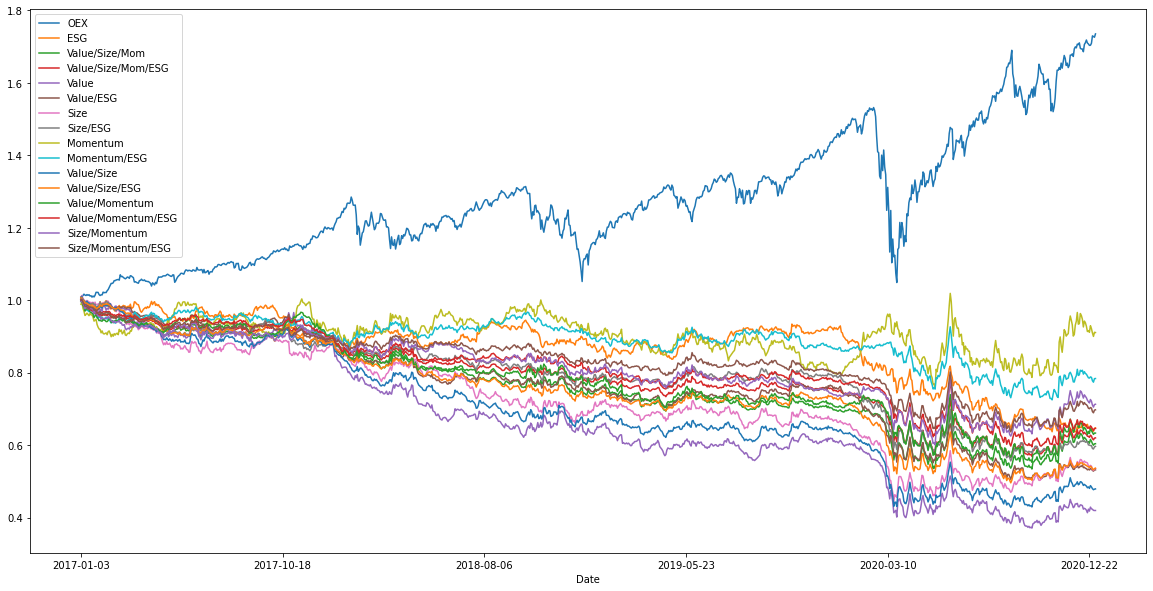

In [53]:
PnL_comp_cumulative.plot(figsize=(20,10))

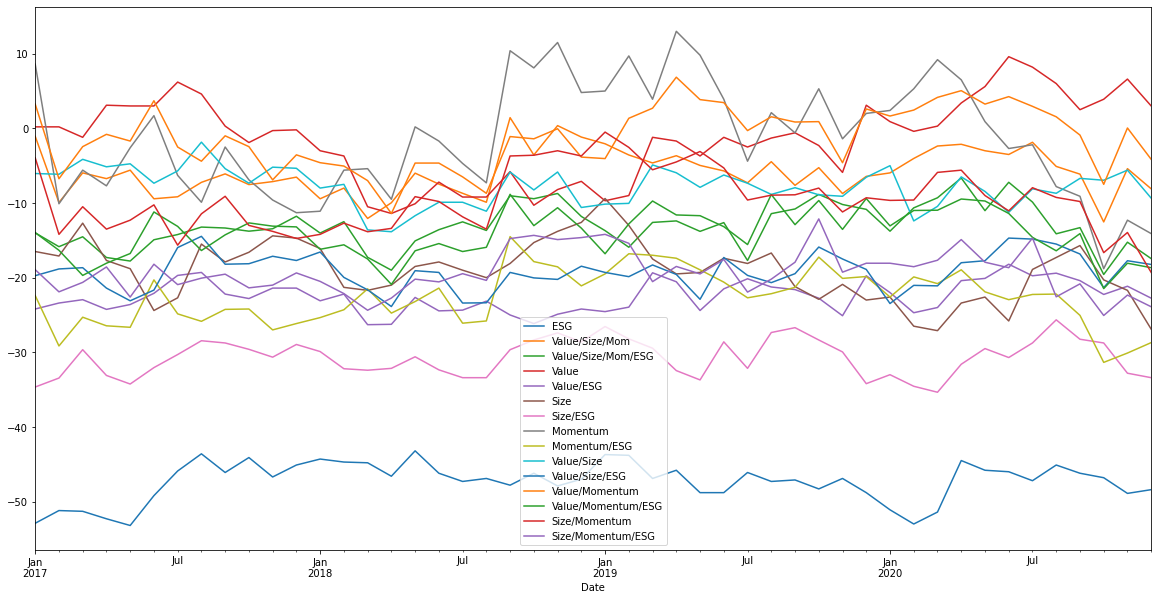

In [54]:
ESG_comp_df.index = pd.to_datetime(ESG_comp_df.index)
ESG_comp_df.resample('M').mean().dropna().plot(figsize=(20,10))

In [55]:
cor = PnL_comp_df_final.corr()
cor.style.apply(lambda x: ["background: yellow" if v > 0.95 and v!=1 else "" for v in x], axis = 1)

,OEX,ESG,Value/Size/Mom,Value/Size/Mom/ESG,Value,Value/ESG,Size,Size/ESG,Momentum,Momentum/ESG,Value/Size,Value/Size/ESG,Value/Momentum,Value/Momentum/ESG,Size/Momentum,Size/Momentum/ESG
OEX,1.000000,0.045781,0.061448,0.064197,0.151518,0.131509,0.049513,0.055209,-0.060068,-0.021388,0.112909,0.106663,0.060790,0.065108,-0.008763,0.008474
ESG,0.045781,1.000000,0.461891,0.637711,0.397010,0.740763,0.495799,0.817337,0.257034,0.697037,0.474877,0.688258,0.392464,0.645055,0.443167,0.694447
Value/Size/Mom,0.061448,0.461891,1.000000,0.977739,0.880008,0.852031,0.856165,0.793606,0.735148,0.779321,0.933852,0.906903,0.963000,0.947396,0.945413,0.915310
Value/Size/Mom/ESG,0.064197,0.637711,0.977739,1.000000,0.858181,0.915207,0.860845,0.882582,0.699260,0.841716,0.923364,0.950439,0.929181,0.975386,0.925902,0.959205
Value,0.151518,0.397010,0.880008,0.858181,1.000000,0.910648,0.730316,0.678424,0.418081,0.511218,0.942541,0.894809,0.859506,0.840717,0.677195,0.678043
Value/ESG,0.131509,0.740763,0.852031,0.915207,0.910648,1.000000,0.757733,0.864504,0.421714,0.687965,0.903646,0.964771,0.805770,0.905730,0.695159,0.808902
Size,0.049513,0.495799,0.856165,0.860845,0.730316,0.757733,1.000000,0.905593,0.407568,0.553437,0.916573,0.902723,0.685235,0.727448,0.825291,0.830378
Size/ESG,0.055209,0.817337,0.793606,0.882582,0.678424,0.864504,0.905593,1.000000,0.395935,0.707610,0.840026,0.935053,0.646295,0.797667,0.763978,0.890079
Momentum,-0.060068,0.257034,0.735148,0.699260,0.418081,0.421714,0.407568,0.395935,1.000000,0.872106,0.444060,0.442345,0.823655,0.766280,0.852039,0.770970
Momentum/ESG,-0.021388,0.697037,0.779321,0.841716,0.511218,0.687965,0.553437,0.707610,0.872106,1.000000,0.569920,0.676688,0.809837,0.895161,0.856569,0.923649


In [56]:
cor_4 = PnL_comp_df_final[["ESG", "Value", "Size", "Momentum"]].corr()
cor_4

,ESG,Value,Size,Momentum
ESG,1.000000,0.397010,0.495799,0.257034
Value,0.397010,1.000000,0.730316,0.418081
Size,0.495799,0.730316,1.000000,0.407568
Momentum,0.257034,0.418081,0.407568,1.000000


### **CONCLUSION**

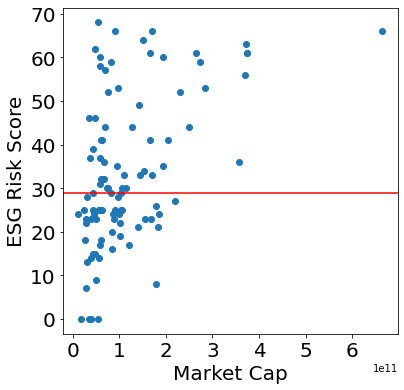

29.0
68


array([ 0., 23., 29., 45., 68.])

In [57]:
size = pd.read_csv("size_factor.csv")
size_slice = size[(size.year == 2015) & (size.month == 1)].T[2:].reset_index()
size_slice.columns = ["Ticker", "Market Cap"]
size_slice = size_slice.set_index("Ticker")
esg_slice = esg_data[(esg_data.year == 2015) & (esg_data.month == 1)][["Ticker", "current_RRI"]].set_index("Ticker")
common = list(set(list(size_slice.index)) & set(list(esg_slice.index)))
size_slice = size_slice[size_slice.index.isin(common)]
esg_slice = esg_slice[esg_slice.index.isin(common)]

plt.figure(figsize = (6, 6))
plt.scatter(size_slice, esg_slice)
plt.xlabel("Market Cap", fontsize = 20)
plt.ylabel("ESG Risk Score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axhline(y = esg_slice.current_RRI.median(), color = 'red')
plt.show()

print(esg_slice.current_RRI.median())
print(esg_slice.current_RRI.max())
np.quantile(esg_slice.current_RRI, [0, 0.25, 0.5, 0.75, 1])

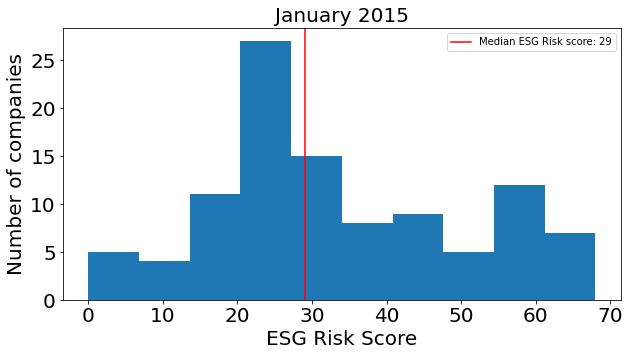

In [58]:
plt.figure(figsize = (10, 5))
plt.hist(list(esg_slice["current_RRI"]))
plt.axvline(x = esg_slice.current_RRI.median(), color = 'red', label = "Median ESG Risk score: 29")
plt.xlabel("ESG Risk Score", fontsize = 20)
plt.ylabel("Number of companies", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("January 2015", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

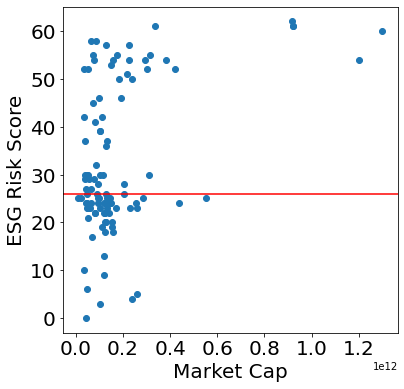

26.0
62


array([ 0., 23., 26., 48., 62.])

In [59]:
size = pd.read_csv("size_factor.csv")
size_slice = size[(size.year == 2020) & (size.month == 12)].T[2:].reset_index()
size_slice.columns = ["Ticker", "Market Cap"]
size_slice = size_slice.set_index("Ticker")
esg_slice = esg_data[(esg_data.year == 2020) & (esg_data.month == 12)][["Ticker", "current_RRI"]].set_index("Ticker")
common = list(set(list(size_slice.index)) & set(list(esg_slice.index)))
size_slice = size_slice[size_slice.index.isin(common)]
esg_slice = esg_slice[esg_slice.index.isin(common)]

plt.figure(figsize = (6, 6))
plt.scatter(size_slice, esg_slice)
plt.xlabel("Market Cap", fontsize = 20)
plt.ylabel("ESG Risk Score", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.axhline(y = esg_slice.current_RRI.median(), color = 'red')
plt.show()

print(esg_slice.current_RRI.median())
print(esg_slice.current_RRI.max())
np.quantile(esg_slice.current_RRI, [0, 0.25, 0.5, 0.75, 1])

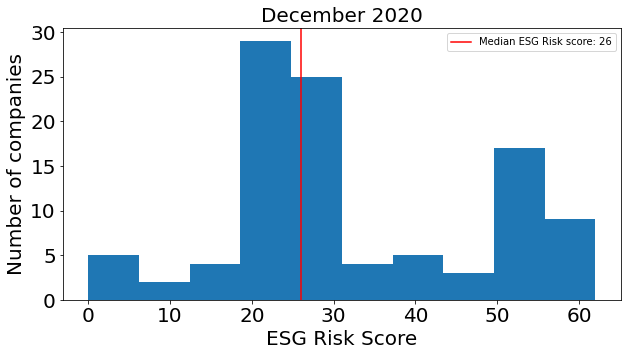

In [60]:
plt.figure(figsize = (10, 5))
plt.hist(list(esg_slice["current_RRI"]))
plt.axvline(x = esg_slice.current_RRI.median(), color = 'red', label = "Median ESG Risk score: 26")
plt.xlabel("ESG Risk Score", fontsize = 20)
plt.ylabel("Number of companies", fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title("December 2020", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()